# 🎯<font color=blue size=6>Challenge Telecom X: Análisis de evasión de clientes - Parte 2</font>

<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1l5Ux2MaZCnJ7gHQSGb_vhqE_KR66PGio"
       alt="Imagen de portada"
       width="600" />
</p>

Autor: Miguel Ángel Toro Romo

Fecha: 08-08-2025



---

🎯 Misión

El objetivo es tener un modelo predictivo capaz de prever qué clientes tienen mayor probabilidad de cancelar sus servicios.

La empresa quiere anticiparse al problema de la cancelación, y debemos construir un pipeline robusto para esta etapa inicial de modelado.

🧠 <font color=red size=4>Este es un problema de clasificación binaria.</font>

🔷 Variable objetivo binaria (Churn = 1 o 0):
¿El cliente se irá o no?


✅ Modelos recomendados: Modelos de clasificación.

Probaremos:

*   DecisionTreeClassifier
*   RandomForestClassifier
*   CatBoost






---


🧠 Principales tareas del Desafío

✅Preparar los datos para el modelado (tratamiento, codificación, normalización).

✅Realizar análisis de correlación y selección de variables.

✅Entrenar dos o más modelos de clasificación.

✅Evaluar el rendimiento de los modelos con métricas.

✅Interpretar los resultados, incluyendo la importancia de las variables.

✅Crear una conclusión estratégica señalando los principales factores que influyen en la cancelación.


---



### ⚙️<font color=blue size=5>Bibliotecas utilizadas</font>

In [14]:
# Bibliotecas utilizadas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib
import pickle
import random
import warnings
warnings.filterwarnings('ignore')

from IPython.display import HTML, display

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve,
                             roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay,
                             recall_score,accuracy_score, precision_score, make_scorer,f1_score)

from sklearn.model_selection import (train_test_split, GridSearchCV, StratifiedKFold, KFold,
                                     cross_validate, RandomizedSearchCV, cross_val_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline as imbpipeline

from scipy import stats
from scipy.stats import t

In [15]:
# importamos catboost
!pip install catboost
from catboost import CatBoostClassifier


## 🔧<font color=blue size=5>Funciones</font>

### Impresión personalizada

In [16]:
# función para impresiones con características especiales
def big_print(text, size=20, color="black"):
    print("\n")
    display(HTML(f"<span style='font-size: {size}px; color: {color};'>{text}</span>"))

### Generación datos nuevos

In [17]:
# función para generar datos de prueba nuevos con características aleatorias
# con tenure entre 0 y 6, ya que son los meses de mayor deserción
def generar_registro_cliente():
    tenure = random.randint(0, 6)
    Charges_Monthly = 65
    Charges_Total = tenure * Charges_Monthly

    return {
        'customerID': f'{random.randint(1000, 9999)}-XYZ',
        'gender': random.choice(['Male', 'Female']),
        'SeniorCitizen': random.choice([0, 1]),
        'Partner': random.choice(['Yes', 'No']),
        'Dependents': random.choice(['Yes', 'No']),
        'tenure': tenure,
        'PhoneService': random.choice(['Yes', 'No']),
        'MultipleLines': random.choice(['Yes', 'No', 'No phone service']),
        'InternetService': random.choice(['DSL', 'Fiber optic', 'No']),
        'OnlineSecurity': random.choice(['Yes', 'No', 'No internet service']),
        'OnlineBackup': random.choice(['Yes', 'No', 'No internet service']),
        'DeviceProtection': random.choice(['Yes', 'No', 'No internet service']),
        'TechSupport': random.choice(['Yes', 'No', 'No internet service']),
        'StreamingTV': random.choice(['Yes', 'No', 'No internet service']),
        'StreamingMovies': random.choice(['Yes', 'No', 'No internet service']),
        'Contract': random.choice(['Month-to-month', 'One year', 'Two year']),
        'PaperlessBilling': random.choice(['Yes', 'No']),
        'PaymentMethod': random.choice([
            'Electronic check', 'Mailed check',
            'Bank transfer (automatic)', 'Credit card (automatic)'
        ]),
        'Charges.Monthly': Charges_Monthly,
        'Charges.Total': Charges_Total
    }


### mapeo de columnas binarias

In [18]:
# función para mapear columnas Yes y No
# Transforma columnas categóricas que contienen 'Yes' a variables binarias:
#    'Yes' -> 1, todo lo demás -> 0.
#   Parámetro:
#        df (pd.DataFrame): DataFrame original.
#    Retorna:
#       pd.DataFrame: DataFrame con las columnas transformadas.
def map_yes_to_binary(df):

    df_copy = df.copy()

    for col in df_copy.columns:
        if df_copy[col].dtype == 'object':
            unique_vals = df_copy[col].dropna().unique()
            if 'Yes' in unique_vals:
                # Mapea 'Yes' a 1, todo lo demás a 0
                df_copy[col] = df_copy[col].apply(lambda x: 1 if x == 'Yes' else 0)

    return df_copy


### Despliegue de matriz de confusión

In [19]:
# función para mostrar matriz de confusión
def plot_confusion_matrix(y_test, y_previsto, modelo:str):
  # creamos la matriz de confusión
  cm = confusion_matrix(y_test, y_previsto)

  # creamos el gráfico de la matriz de confusión
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn No', 'Churn Sí'])
  disp.plot(cmap='Blues')
  plt.title(f'Matriz de Confusión {modelo}', color='firebrick', fontsize=12)

  # guadamos gráfico como archivo png
  archivo_matriz_confusion = str(f'MC_{modelo}_1.png')
  plt.savefig(archivo_matriz_confusion, dpi=300, bbox_inches='tight')
  plt.grid(False)
  plt.show()

### Despliegue de curva ROC

In [20]:
# Función para mostrar gráfico de curva ROC
def plot_roc_curve(modelo, X_test, y_test, titulo):

  # revisemos la curva AUC para este modelo
  modelo.fit(X_train, y_train)

  # Predecir probabilidades sobre conjunto de prueba
  y_scores = modelo.predict_proba(X_test)[:, 1]  # Probabilidad de clase 1

  # Calcular fpr, tpr y auc
  fpr, tpr, thresholds = roc_curve(y_test, y_scores)
  auc = roc_auc_score(y_test, y_scores)

  # configuramos display del gráfico
  plt.figure(figsize=(6, 5), facecolor='lightyellow')
  ax = plt.gca()
  ax.set_facecolor('honeydew')

  plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})', linewidth=2)
  plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
  plt.xlabel('Tasa de Falsos Positivos (FPR)')
  plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
  plt.title(f'Curva ROC - {titulo}',fontsize=14)
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.tight_layout()

  # guardamos gráfico como archivo png
# reemplazamos ' ' por '_' en titulo
  titulo = titulo.replace(' ', '_')
  archivo_roc = str(f'ROC_{titulo}.png')
  plt.savefig(archivo_roc, dpi=300, bbox_inches='tight')
  plt.show()

### Recopilación de métricas de modelos

In [21]:
# Lista para almacenar los resultados
metricas_modelos = []

# Función para calcular métricas
def calcular_metricas(modelo_nombre, y_true, y_pred):
    return {
        'Modelo': modelo_nombre,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision_Clase_1': precision_score(y_true, y_pred, pos_label=1),
        'Recall_Clase_1': recall_score(y_true, y_pred, pos_label=1),
        'F1-Score_Clase_1': f1_score(y_true, y_pred, pos_label=1)
    }

## <font color=blue size=5>Extracción del Archivo Normalizado del Challenge anterior</font>



---

En el challenge anterior terminamos con un dataset normalizado, donde se habían eliminado registros con valores nulos.

Utilizaremos ese dataset para este challenge.


---



In [22]:
# leemos archivo /content/df_normalizado.csv
df = pd.read_csv('/content/df_normalizado.csv')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Churn             7043 non-null   object 
 2   gender            7043 non-null   object 
 3   SeniorCitizen     7043 non-null   int64  
 4   Partner           7043 non-null   object 
 5   Dependents        7043 non-null   object 
 6   tenure            7043 non-null   int64  
 7   PhoneService      7043 non-null   object 
 8   MultipleLines     7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  Contract          7043 non-null   object 


In [24]:
df.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


In [25]:
# imprimimos valores únicos de las columnas del df
for col in df.columns:
  print(f'{col}: {df[col].unique()}')

customerID: ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
Churn: ['No' 'Yes']
gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['Yes' 'No']
tenure: [ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 37 49 66 67
 20 43 59 12 27  2 25 29 14 35 64 39 40 11  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 31 36 17 18 51 38 42
  0]
PhoneService: ['Yes' 'No']
MultipleLines: ['No' 'Yes' 'No phone service']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['Yes' 'No' 'No internet service']
StreamingTV: ['Yes' 'No' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['One year' 'Month-to-month' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Mailed check' 'Electronic check' 'Credi

## <font color=blue size=5>Análisis exploratorio de datos</font>

###<font color=blue size=5>Verificación de la Proporción de Cancelación (Churn)</font>

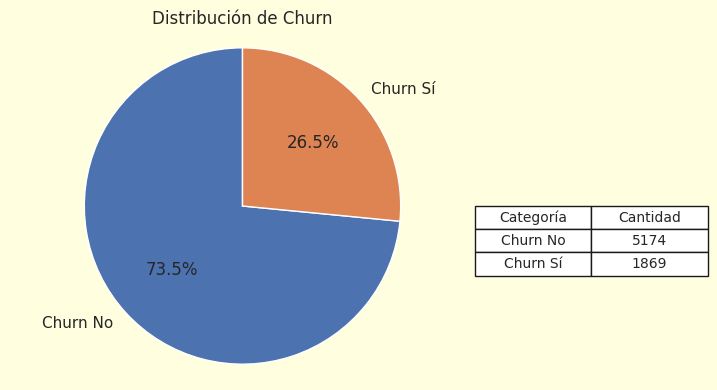

In [26]:
# Análisis de distribución de clases Churn Yes y Churn No
# creamos gráfico de torta con porcentajes y tabla con valores absolutos
sns.set(style="whitegrid")

# Contamos los valores
valores = df['Churn'].value_counts()
etiquetas = ['Churn No', 'Churn Sí']
porcentajes = valores.values

# Creamos la figura y el eje
fig, ax = plt.subplots(figsize=(6, 6))

# Personalizamos colores de fondo y área de gráfico
fig.patch.set_facecolor('lightyellow')   # Fondo de toda la figura
ax.set_facecolor('honeydew')             # Fondo del área del gráfico

# Gráfico de torta
wedges, texts, autotexts = ax.pie(
    porcentajes,
    labels=etiquetas,
    autopct='%1.1f%%',
    startangle=90
)
ax.axis('equal')  # Círculo perfecto

# Agregamos tabla con valores absolutos
tabla_data = [[etiquetas[i], porcentajes[i]] for i in range(len(etiquetas))]
col_labels = ['Categoría', 'Cantidad']

tabla = ax.table(
    cellText=tabla_data,
    colLabels=col_labels,
    cellLoc='center',
    loc='bottom',
    bbox=[1.0, 0.3, 0.5, 0.2]  # [x, y, width, height]
)

tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
plt.title('Distribución de Churn')
plt.subplots_adjust(bottom=0.3)  # Espacio para la tabla

# guardamos gráfico como imagen png
plt.savefig('graf_01_torta_churn.png', dpi=300, bbox_inches='tight')

plt.show()

###<font color=blue size=5>Distribución de Churn Yes por tenure</font>

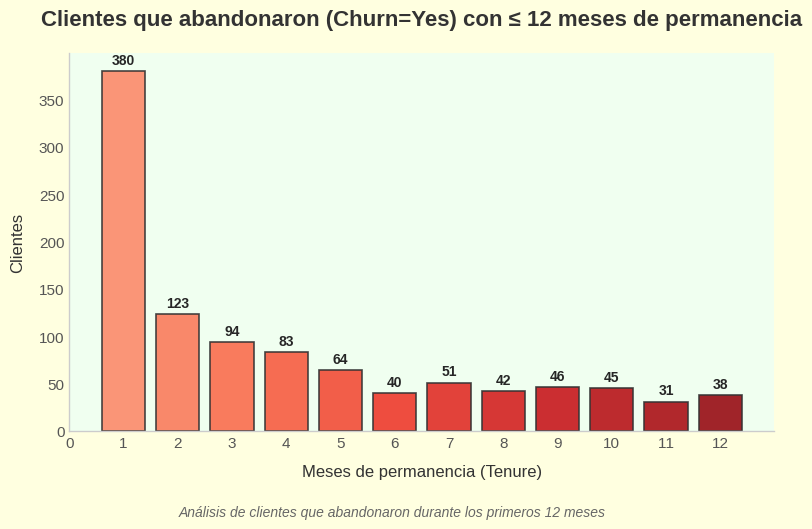

In [27]:
# Análisis de Churn por tenure
# Filtramos clientes con Churn = Yes y tenure ≤ 12
churned_short_tenure = df[(df['Churn'] == 'Yes') & (df['tenure'] <= 12)]

# Contamos clientes por tenure
tenure_counts = churned_short_tenure['tenure'].value_counts().sort_index().reset_index()
tenure_counts.columns = ['Tenure', 'Clientes']

# Configuramos estilos
plt.style.use('seaborn-v0_8-whitegrid')

# Creamos figura con fondo personalizado
fig = plt.figure(figsize=(8, 5), facecolor='lightyellow')
ax = fig.add_subplot(facecolor='honeydew')  # Fondo del área del gráfico

# Colores para las barras usando un gradiente
colors = [plt.cm.Reds(i) for i in np.linspace(0.4, 0.9, len(tenure_counts))]

# Creamos gráfico de barras
bars = ax.bar(tenure_counts['Tenure'],
              tenure_counts['Clientes'],
              color=colors,
              edgecolor='#333333',
              linewidth=1.2,
              alpha=0.9)

# Añadimos etiquetas de valores
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center',
                va='bottom',
                fontsize=10,
                fontweight='bold')

# Personalización del gráfico
ax.set_title('Clientes que abandonaron (Churn=Yes) con ≤ 12 meses de permanencia',
             fontsize=16, pad=20, fontweight='bold', color='#333333')
ax.set_xlabel('Meses de permanencia (Tenure)', fontsize=12, labelpad=10, color='#333333')
ax.set_ylabel('Clientes', fontsize=12, labelpad=10, color='#333333')
ax.set_xticks(range(0, 13))
ax.tick_params(axis='both', colors='#555555')

# Decoración adicional
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#cccccc')
ax.spines['bottom'].set_color('#cccccc')

# Añadimos nota explicativa
plt.figtext(0.5, -0.05,
            'Análisis de clientes que abandonaron durante los primeros 12 meses',
            ha='center', fontsize=10, color='#666666', fontstyle='italic')
plt.grid(False)

# Ajustar layout y mostrar
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)  # Espacio para el texto inferior

# guardamos gráfico como archivo png
plt.savefig('graf_02_desercion_primer_año.png', dpi=300, bbox_inches='tight')
plt.show()

###<font color=blue size=5>Categorías con mayor porcentaje de Churn Yes</font>

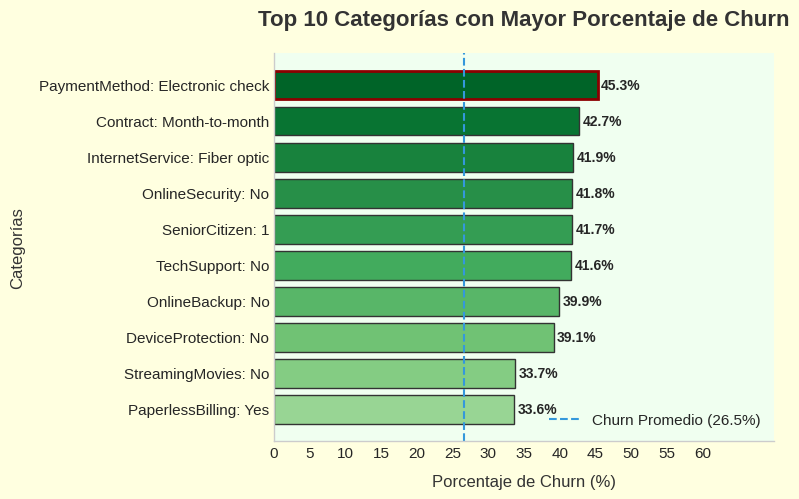

In [28]:
# Analizamos las características con mayor Churn Yes
# Convertir Churn a binario (1 para Yes, 0 para No)
df['Churn_bin'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Lista de características categóricas
categorical_features = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

# Calcular el porcentaje de churn para cada categoría
results = []
for feature in categorical_features:
    # Convertir a string para incluir SeniorCitizen correctamente
    df[feature] = df[feature].astype(str)
    grouped = df.groupby(feature)['Churn_bin'].mean().reset_index()
    grouped['Feature'] = feature
    # Renombrar la columna de categoría para unificar
    grouped.rename(columns={feature: 'Category'}, inplace=True)
    results.append(grouped)

# Combinar todos los resultados
results_df = pd.concat(results, ignore_index=True)
results_df.rename(columns={'Churn_bin': 'Churn_Percentage'}, inplace=True)

# Ordenar y seleccionar las top 10 categorías con mayor churn
top_10 = results_df.sort_values('Churn_Percentage', ascending=False).head(10)

# Ordenar para mejor visualización en el gráfico
top_10 = top_10.sort_values('Churn_Percentage', ascending=True)

# Crear etiquetas combinadas
top_10['Label'] = top_10['Feature'] + ': ' + top_10['Category']

# Creamos figura con fondo personalizado
fig = plt.figure(figsize=(8, 5), facecolor='lightyellow')
ax = fig.add_subplot(facecolor='honeydew')  # Fondo del área del gráfico

# Crear colores con gradiente
colors = plt.cm.Greens(np.linspace(0.4, 0.9, len(top_10)))

# Gráfico de barras horizontales
bars = ax.barh(top_10['Label'],
               top_10['Churn_Percentage'] * 100,
               color=colors,
               edgecolor='#333333',
               height=0.8)

# Añadir valores a las barras
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5,
             bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%',
             va='center',
             fontsize=10,
             fontweight='bold')

# Personalización
plt.title('Top 10 Categorías con Mayor Porcentaje de Churn',
          fontsize=16, pad=20, fontweight='bold', color='#333333')
plt.xlabel('Porcentaje de Churn (%)', fontsize=12, labelpad=10, color='#333333')
plt.ylabel('Categorías', fontsize=12, labelpad=10, color='#333333')

# AJUSTE PRINCIPAL: Limitar eje X al 60%
plt.xlim(0, 70)
plt.xticks(np.arange(0, 61, 5))

# Añadir línea vertical de referencia
avg_churn = df['Churn_bin'].mean() * 100
plt.axvline(x=avg_churn,
            color='#3498db',
            linestyle='--',
            linewidth=1.5,
            label=f'Churn Promedio ({avg_churn:.1f}%)')

# Destacar la barra con mayor churn
max_bar = bars[-1]
max_bar.set_edgecolor('#8b0000')
max_bar.set_linewidth(2)

# Decoración
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#cccccc')
ax.spines['bottom'].set_color('#cccccc')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.legend(loc='lower right')

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.grid(False)

# guardamos gráfico como archivo png
plt.savefig('graf_03_top_10_churn.png', dpi=300, bbox_inches='tight')

plt.show()

In [29]:
# eliminamos Churn_bin
df.drop('Churn_bin', axis=1, inplace=True)

# 🚧<font color=blue size=6>Preparación de datos</font>

## <font color=blue size=5>Eliminación de Columnas Irrelevantes</font>

---
<font size=4>

*   **customerID**: es  una columna generada para identificación de los registros, por lo que no representa información de las características de los clientes.</font>
---

In [30]:
# eliminamos columna customerID
df.drop('customerID', axis=1, inplace=True)
df.head(5)

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


## <font color=blue size=5>Encoding</font>


<font size=4>

*   Para la codificación reemplazaremos los Yes por 1 y los No por 0.

*   Para las columnas categóricas restantes utilizaremos OneHotEncoder
</font>





In [31]:
# mapeamos los Yes a 1, No y No+cualquier_cosa a 0
df = map_yes_to_binary(df)

In [32]:
df.head()

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0,Female,0,1,1,9,1,0,DSL,0,1,0,1,1,0,One year,1,Mailed check,65.6,593.30
1,0,Male,0,0,0,9,1,1,DSL,0,0,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.40
2,1,Male,0,0,0,4,1,0,Fiber optic,0,0,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85
3,1,Male,1,1,0,13,1,0,Fiber optic,0,1,1,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85
4,1,Female,1,1,0,3,1,0,Fiber optic,0,0,0,1,1,0,Month-to-month,1,Mailed check,83.9,267.40


In [33]:
# Separamos características (X) y variable objetivo (y)
X = df.drop(columns=['Churn'])
y = df['Churn']

In [34]:
# Identificamos columnas categóricas restantes a codificar
categorical_cols = ['gender', 'InternetService', 'Contract', 'PaymentMethod']

# Configuramos el transformador
preprocessor = ColumnTransformer(transformers=[
                                ('cat',
                                 OneHotEncoder(drop='first', sparse_output=False),
                                 categorical_cols)],
                                  remainder='passthrough')

In [35]:
# Aplicamos el encoded a las características
X_encoded = preprocessor.fit_transform(X)

In [36]:
# Convertimos a DataFrame con nombres de columnas
# Obtenemos nombres de características después del encoding
feature_names = preprocessor.get_feature_names_out()
X_encoded_df = pd.DataFrame(X_encoded, columns=feature_names)
X_encoded_df.head()

,cat__gender_Male,cat__InternetService_Fiber optic,cat__InternetService_No,cat__Contract_One year,cat__Contract_Two year,cat__PaymentMethod_Credit card (automatic),cat__PaymentMethod_Electronic check,cat__PaymentMethod_Mailed check,remainder__SeniorCitizen,remainder__Partner,...,remainder__MultipleLines,remainder__OnlineSecurity,remainder__OnlineBackup,remainder__DeviceProtection,remainder__TechSupport,remainder__StreamingTV,remainder__StreamingMovies,remainder__PaperlessBilling,remainder__Charges.Monthly,remainder__Charges.Total
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,...,0,0,1,0,1,1,0,1,65.6,593.3
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,...,1,0,0,0,0,0,1,0,59.9,542.4
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,...,0,0,0,1,0,0,0,1,73.9,280.85
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,...,0,0,1,1,0,1,1,1,98.0,1237.85
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,...,0,0,0,0,1,1,0,1,83.9,267.4


In [37]:
# generamos dataframe completo con X_encoded_df + y
df_codificado = pd.concat([X_encoded_df, y], axis=1)
df_codificado.head()

,cat__gender_Male,cat__InternetService_Fiber optic,cat__InternetService_No,cat__Contract_One year,cat__Contract_Two year,cat__PaymentMethod_Credit card (automatic),cat__PaymentMethod_Electronic check,cat__PaymentMethod_Mailed check,remainder__SeniorCitizen,remainder__Partner,...,remainder__OnlineSecurity,remainder__OnlineBackup,remainder__DeviceProtection,remainder__TechSupport,remainder__StreamingTV,remainder__StreamingMovies,remainder__PaperlessBilling,remainder__Charges.Monthly,remainder__Charges.Total,Churn
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,...,0,1,0,1,1,0,1,65.6,593.3,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,...,0,0,0,0,0,1,0,59.9,542.4,0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,...,0,0,1,0,0,0,1,73.9,280.85,1
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,...,0,1,1,0,1,1,1,98.0,1237.85,1
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,...,0,0,0,1,1,0,1,83.9,267.4,1


<font size=4>Existe una correlación fuerte entre **Charges.Monthly** y **Charges.Total**, probablemente porque existe una función entre ellas y el valor de tenure.
Por lo tanto, parece conveniente eliminar Charges.Monthly para simplificar el dataset.</font>


In [38]:
# eliminamos remainder__Charges.Monthly
df_codificado.drop('remainder__Charges.Monthly', axis=1, inplace=True)
df_codificado.head()

,cat__gender_Male,cat__InternetService_Fiber optic,cat__InternetService_No,cat__Contract_One year,cat__Contract_Two year,cat__PaymentMethod_Credit card (automatic),cat__PaymentMethod_Electronic check,cat__PaymentMethod_Mailed check,remainder__SeniorCitizen,remainder__Partner,...,remainder__MultipleLines,remainder__OnlineSecurity,remainder__OnlineBackup,remainder__DeviceProtection,remainder__TechSupport,remainder__StreamingTV,remainder__StreamingMovies,remainder__PaperlessBilling,remainder__Charges.Total,Churn
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,...,0,0,1,0,1,1,0,1,593.3,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,...,1,0,0,0,0,0,1,0,542.4,0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,...,0,0,0,1,0,0,0,1,280.85,1
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,...,0,0,1,1,0,1,1,1,1237.85,1
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,...,0,0,0,0,1,1,0,1,267.4,1


In [39]:
# guardamos dataframe df_codificado como archivo csv
df_codificado.to_csv('df_codificado.csv', index=False)

<font color=red size=4>A partir de ahora trabajaremos con el dataframe codificado guardado</font>

##<font color=blue size=5>Análisis de correlación de variables</font>

,Correlación
cat__InternetService_Fiber optic,0.308020
cat__PaymentMethod_Electronic check,0.301919
remainder__PaperlessBilling,0.191825
remainder__SeniorCitizen,0.150889
remainder__Partner,-0.150448
remainder__Dependents,-0.164221
remainder__TechSupport,-0.164674
remainder__OnlineSecurity,-0.171226
cat__Contract_One year,-0.177820
remainder__Charges.Total,-0.198324


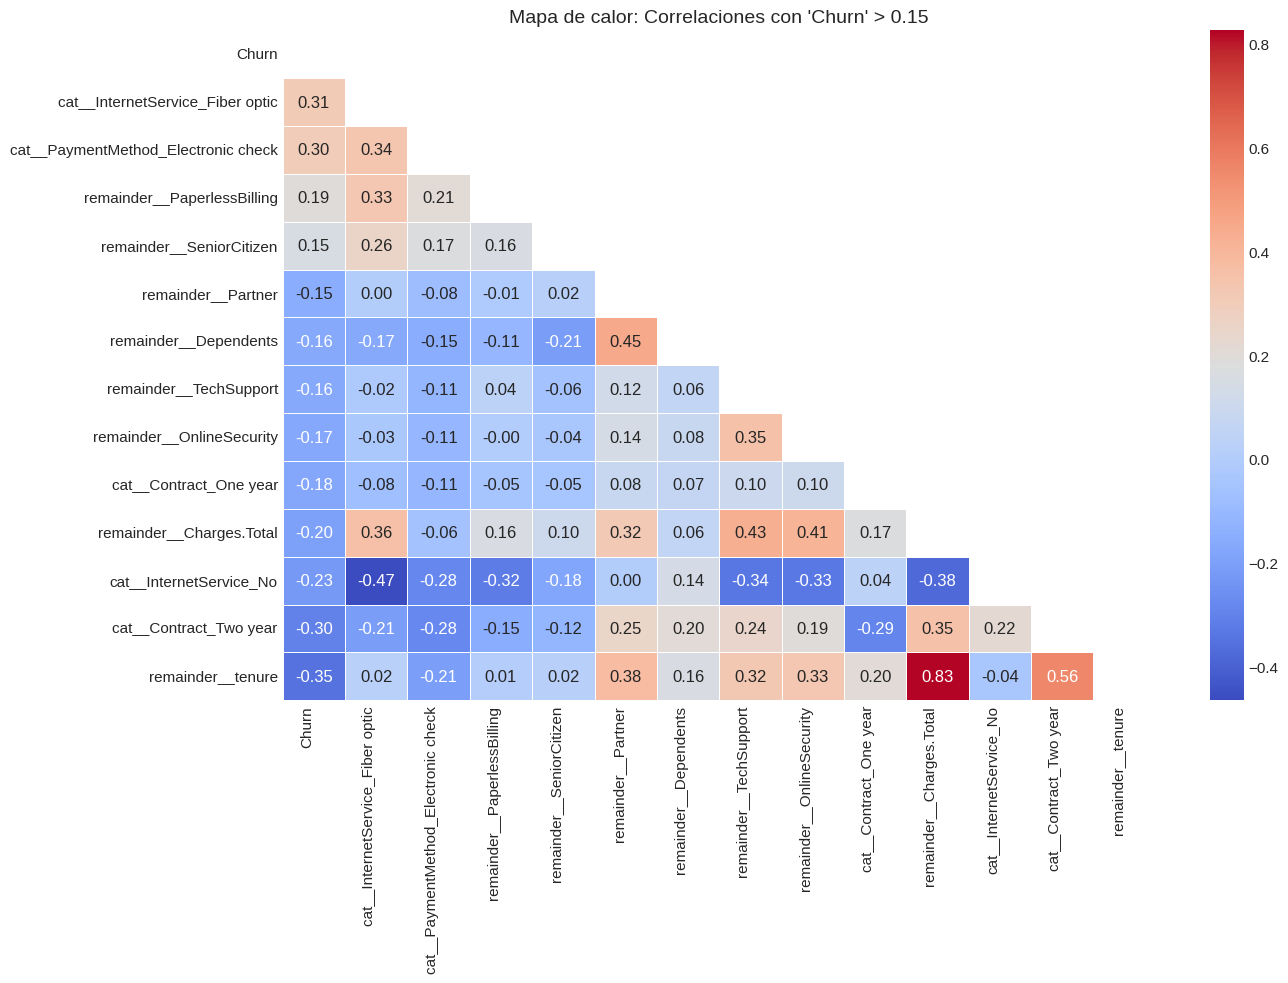

In [40]:
# Analizamos la correlación de las variables con Churn, filtrando un umbral de correlación en 15%
df = pd.read_csv('/content/df_codificado.csv')
umbral = 0.15

# Matriz de correlación
corr_matrix = df.corr()

# Obtenemos correlaciones con 'Churn'
correlaciones_churn = corr_matrix['Churn'].drop('Churn')

# Filtramos por umbral
correlaciones_filtradas = correlaciones_churn[abs(correlaciones_churn) > umbral].sort_values(ascending=False)

# Mostramos tabla de correlaciones ordenada
big_print(f"Correlaciones con 'Churn' mayores a {umbral}%",20,'brown')
display(correlaciones_filtradas.to_frame(name='Correlación'))

# Creamos submatriz para heatmap
variables = ['Churn'] + list(correlaciones_filtradas.index)
filtered_corr_matrix = corr_matrix.loc[variables, variables]

# Creamos máscara inferior
mask = np.triu(np.ones_like(filtered_corr_matrix, dtype=bool))

# Plot del heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(filtered_corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f"Mapa de calor: Correlaciones con 'Churn' > {umbral}",fontsize=14)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.grid(False)

# guardamos mapa de calor como archivo png
plt.savefig('mapa_de_calor_correlacion_churn.png', dpi=300, bbox_inches='tight')
plt.show()

##<font color=blue size=5>Análisis de multicolinealidad</font>



---





*   <font size=4>Los modelos a probar no son sensibles a la multicolinealidad, por lo tanto omitiremos este análisis ya que no aporta para la elección del modelo apropiado para este problema.</font>





---



# 📦<font color=blue size=6>Modelos probados</font>

Probaremos:

*   DecisionTreeClassifier
*   RandomForestClassifier
*   CatBoost

<font color=red size=4>
Recordemos las fórmulas para el cálculo de las métricas de los modelos de clasificación</font>

<img src="https://i.ibb.co/6Jp6rKyC/Captura-de-tela-2025-03-22-120744.png" width="400">

## <font color=blue size=5>DecisionTreeClassifier</font>

### <font color=blue size=5>DecisionTreeClassifier sin optimizaci0nes</font>

              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1035
           1       0.54      0.48      0.51       374

    accuracy                           0.75      1409
   macro avg       0.68      0.67      0.67      1409
weighted avg       0.75      0.75      0.75      1409



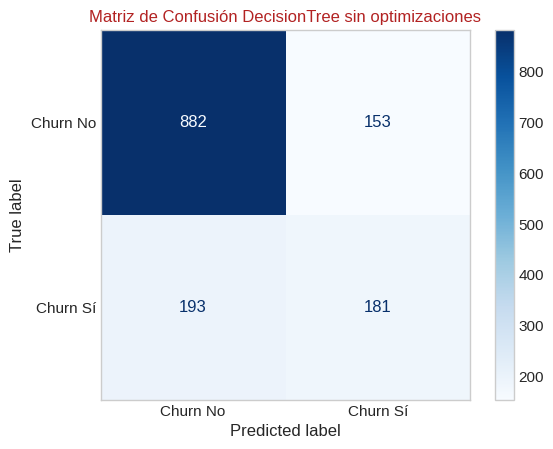

In [41]:
# Separamos variables dependiente e independientes
# leemos archivo guardado
df = pd.read_csv('df_codificado.csv')

X = df.drop('Churn', axis=1)
y = df['Churn']

# Separamos Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# creamos modelo DecisionTreeClasifier
modelo = DecisionTreeClassifier(random_state=42,max_depth=10)

# entrenamos con conjunto de train
modelo.fit(X_train, y_train)
# revisemos las métricas y la matriz de confusión

y_previsto = modelo.predict(X_test)

big_print("Reporte de Clasificación DecisionTree sin optimizaciones:", 20,'brown')
print(classification_report(y_test, y_previsto))

# mostramos matriz de confusión
plot_confusion_matrix(y_test, y_previsto, 'DecisionTree sin optimizaciones')


<font color=red size=4>
¿Qué significa esta matriz de confusión?</font>

1. que predijo correctamente 899 Churn No (Verdaderos Negativos TN) **87%**

2. que predijo erróneamente 136 Churn No como Churn Sí (Falsos Positivos FP)

3. predijo correctamente 196 Churn Sí (Verdaderos Positivos TP) **48%**

4. predijo erróneamente 178 Churn Sí como Churn No (Falsos Negativos FN)

Esto nos muestra que el modelo es prácticamente inútil para predecir correctamente los Churn Sí ya que solo identifica correctamente al **48%** de ellos a pesar de que identifica correctamente a casi al **87%** de los Churn No.

Este modelo no es útil porque nuestro objetivo es identificar lo mejor posible los clientes con Churn Sí.

**Nuestro objetivo es encontrar un modelo donde el recall para Churn Sí sea el mayor posible.**


---



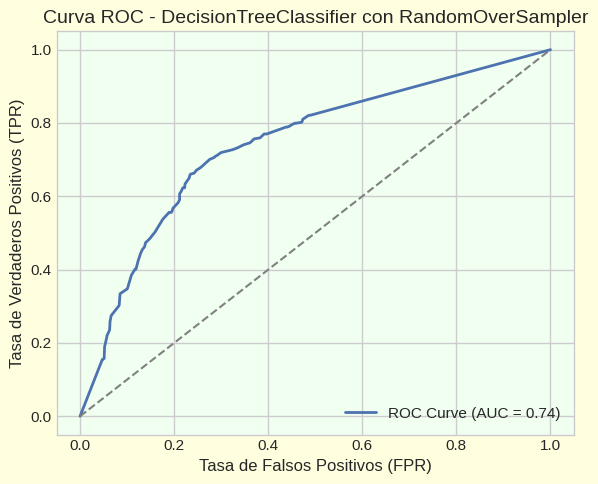

In [42]:
# mostramos curva ROC
plot_roc_curve(modelo, X_test, y_test, 'DecisionTreeClassifier con RandomOverSampler')

###<font color=blue size=5> DecisionTreeClassifier con Validación cruzada</font>

Accuracy  : 0.759 ± 0.010
Precision : 0.553 ± 0.026
Recall    : 0.492 ± 0.037
F1        : 0.519 ± 0.020




              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1035
           1       0.54      0.48      0.51       374

    accuracy                           0.75      1409
   macro avg       0.68      0.67      0.67      1409
weighted avg       0.75      0.75      0.75      1409



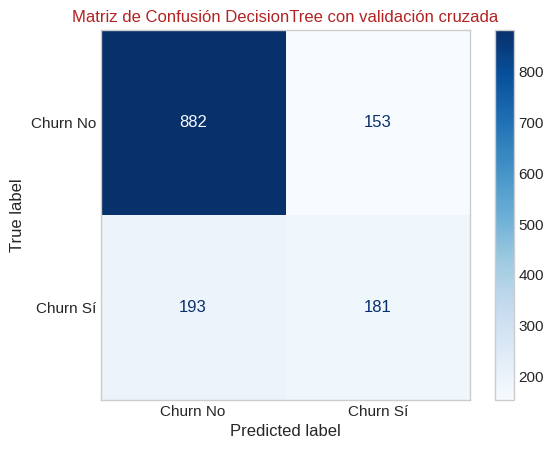

In [43]:
# Separamos variables predictoras (X) y variable objetivo (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Separamos en conjunto de entrenamiento y prueba (stratify mantiene proporción de clases)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Creamos modelo
modelo = DecisionTreeClassifier(random_state=42, max_depth=10)

# Validación cruzada sobre el conjunto de entrenamiento
scoring = ['accuracy', 'precision', 'recall', 'f1']
cv_resultados = cross_validate(
    modelo, X_train, y_train, cv=5, scoring=scoring, return_train_score=False
)

# Mostramos resultados promedios de la validación cruzada
big_print("Validación cruzada (solo en TRAIN)",20,'brown')
for metrica in scoring:
    puntajes = cv_resultados[f'test_{metrica}']
    print(f"{metrica.capitalize():<10}: {puntajes.mean():.3f} ± {puntajes.std():.3f}")

# Entrenamos el modelo final con todos los datos de entrenamiento
modelo.fit(X_train, y_train)

# Predecimos con datos de test (jamás vistos por el modelo)
y_pred = modelo.predict(X_test)

# Reporte de clasificación
big_print("Reporte de Clasificación DecisionTree con CrossValidation", 20,'firebrick')
print(classification_report(y_test, y_pred))

# mostramos matriz de confusión
plot_confusion_matrix(y_test, y_pred, 'DecisionTree con validación cruzada')

<font color=red size=4>
¿Qué significa esta matriz de confusión?</font>

1. que predijo correctamente 894 Churn No (Verdaderos Negativos TN) **86%**

2. que predijo erróneamente 141 Churn No como Churn Sí (Falsos Positivos FP)

3. predijo correctamente 184 Churn Sí (Verdaderos Positivos TP) **49%**

4. predijo erróneamente 190 Churn Sí como Churn No (Falsos Negativos FN)


<font color=red size=4>
¿Qué significan las métricas obtenidas con a validación cruzada?</font>



1.   **DecisionTreeClassifier** entrenado con validación cruzada (CV) muestra las mismas métricas que el modelo entrenado sin CV (usando un solo train-test split), esto nos indica:

  - Estabilidad del modelo: El modelo es robusto ante diferentes particiones de datos.

  - No es sensible a variaciones aleatorias en la división entrenamiento/prueba.

2. Calidad de los datos: Los datos están bien distribuidos y no hay sesgos fuertes o patrones ocultos que afecten el rendimiento según cómo se dividan.

3. El tamaño del dataset es adecuado (no es demasiado pequeño), lo que reduce la variabilidad en las métricas entre diferentes splits.

4. Ausencia de overfitting significativo
El modelo generaliza bien: su rendimiento en datos no vistos es consistente, independientemente de cómo se evalúe (CV vs. holdout simple).

###<font color=blue size=5> DecisionTreeClassifier con balanceo de clases</font>



---


<font color=red size=4>Probaremos cuatro técnicas de balanceo</font>


*   RandomOverSampler
*   SMOTE
*   ADASYN
*   TomekLinks


---






              precision    recall  f1-score   support

           0       0.86      0.76      0.81      1035
           1       0.51      0.67      0.58       374

    accuracy                           0.74      1409
   macro avg       0.68      0.72      0.69      1409
weighted avg       0.77      0.74      0.75      1409



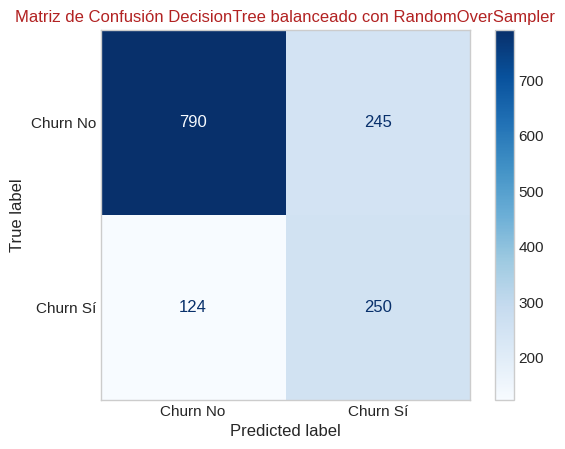

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1035
           1       0.54      0.62      0.57       374

    accuracy                           0.76      1409
   macro avg       0.70      0.71      0.70      1409
weighted avg       0.77      0.76      0.76      1409



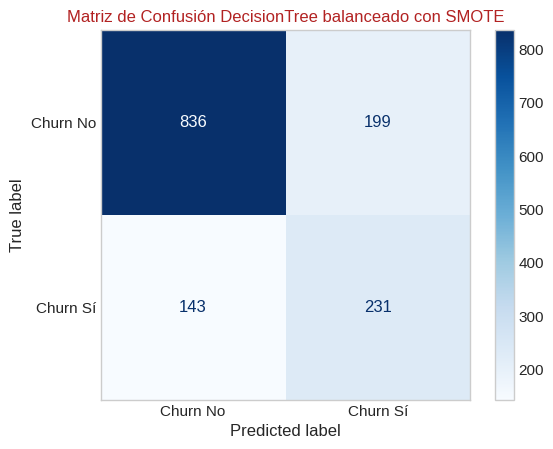

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1035
           1       0.53      0.66      0.59       374

    accuracy                           0.76      1409
   macro avg       0.70      0.73      0.71      1409
weighted avg       0.78      0.76      0.76      1409



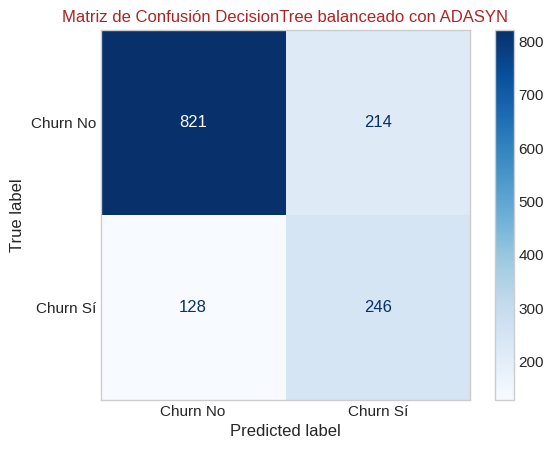

              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1035
           1       0.53      0.59      0.55       374

    accuracy                           0.75      1409
   macro avg       0.68      0.70      0.69      1409
weighted avg       0.76      0.75      0.75      1409



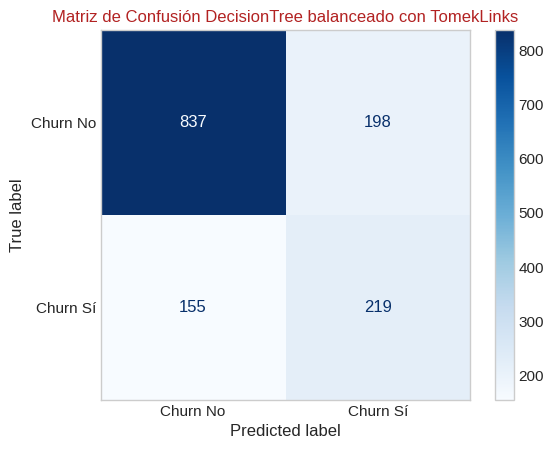

             Técnica  Accuracy  Precision    Recall  F1-score
0  RandomOverSampler  0.738112   0.505051  0.668449  0.575374
2             ADASYN  0.757275   0.534783  0.657754  0.589928
1              SMOTE  0.757275   0.537209  0.617647  0.574627
3         TomekLinks  0.749468   0.525180  0.585561  0.553729


In [44]:
# Cargamos datos
df = pd.read_csv("df_codificado.csv")

# Separamos variables
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Separamos en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Diccionario con técnicas de muestreo
samplers = {
    "RandomOverSampler": RandomOverSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
    "TomekLinks": TomekLinks()
}

# Almacenar resultados
resultados = []

# Entrenamiento y evaluación por técnica
def entrenar_y_evaluar(X_res, y_res, nombre):
    modelo = DecisionTreeClassifier(max_depth=10, random_state=42)
    modelo.fit(X_res, y_res)
    y_pred = modelo.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    resultados.append({
        "Técnica": nombre,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    })

    big_print(f"===== {nombre} =====",20,'brown')
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn No', 'Churn Sí'])
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de Confusión DecisionTree balanceado con {nombre}", color='firebrick', fontsize=12)
    plt.grid(False)
    # guardamos gráfico como archivo png
    plt.savefig(f'MC_DecisionTree_{nombre}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Ejecutar para cada técnica
for nombre, sampler in samplers.items():
    try:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
        entrenar_y_evaluar(X_res, y_res, nombre)
    except Exception as e:
        print(f"Error en {nombre}: {e}")

# Mostrar tabla comparativa
df_resultados = pd.DataFrame(resultados)
big_print("📊 Métricas DecisionTree por Técnica de Balanceo:",20,'brown')
print(df_resultados.sort_values("Recall", ascending=False))




---


<font color=red size=4>Nuestro objetivo es minimizar los falsos negativos:</font>

Es decir, cuando el modelo predice que un cliente no hará churn (0), pero en realidad sí lo hará (1).

El criterio que debemos priorizar es el **Recall** (sensibilidad) para la clase positiva (Churn = 1).

Con este criterio el mejor balanceo de clases lo provee **RandomOverSamplet**, aunque la Precision es la más baja, pero en términos globales tiene también el mejor F1-score.


---






<font color=red size=5>Graficamos Recall y F1 para las cuatro técnicas de balanceo</font>

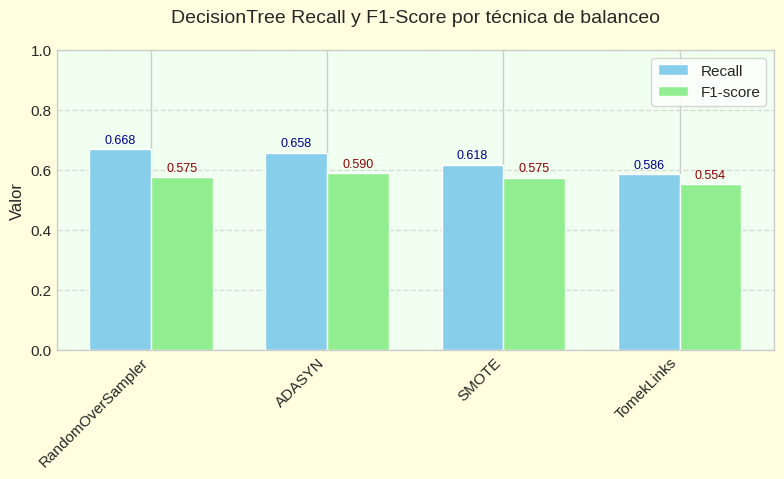

In [45]:
# Ordenar el DataFrame por Recall de mayor a menor
df_sorted = df_resultados.sort_values('Recall', ascending=False)

# Configuración del gráfico
plt.figure(figsize=(8, 4), facecolor='lightyellow')
ax = plt.gca()
ax.set_facecolor('honeydew')

# Configuración de barras
n = len(df_sorted)
bar_width = 0.35
index = np.arange(n)

# Creamos barras para Recall y F1-score
plt.bar(index - bar_width/2, df_sorted['Recall'], bar_width,
        color='skyblue', label='Recall')
plt.bar(index + bar_width/2, df_sorted['F1-score'], bar_width,
        color='lightgreen', label='F1-score')

# Añadimos valores en las barras
for i, (rec, f1) in enumerate(zip(df_sorted['Recall'], df_sorted['F1-score'])):
    plt.text(i - bar_width/2, rec + 0.02, f"{rec:.3f}",
             ha='center', fontsize=9, color='darkblue')
    plt.text(i + bar_width/2, f1 + 0.02, f"{f1:.3f}",
             ha='center', fontsize=9, color='darkred')

# Personalización del gráfico
plt.title('DecisionTree Recall y F1-Score por técnica de balanceo', pad=20, fontsize=14)
plt.ylabel('Valor')
plt.ylim(0, 1)
plt.xticks(index, df_sorted['Técnica'], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(frameon=True, loc='best')

# Mejoramos espaciado
plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.15)

# guardamos gráfico como archivo png
plt.savefig('graf_DTC_recall_por_tecnica_balaceo.png', dpi=300, bbox_inches='tight')
plt.show()

<font color=red size=4>El mejor modelo DecisionTree se obtuvo con RandomOverSampler</font>

<font color=red size=5>Intervalo de confianza del Recall para DecisionTree con RandomOverSamper</font>

In [46]:
# revisemos el intervalo de confianza para el modelo balanceado con RandomOverSampler
# Cargamos el dataset
df = pd.read_csv('df_codificado.csv')

# Separamos variables predictoras y objetivo
X = df.drop('Churn', axis=1)
y = df['Churn']

# Creamos pipeline con RandomOverSampler + modelo
pipeline = imbpipeline([
    ('oversample', RandomOverSampler(random_state=42)),
    ('modelo', DecisionTreeClassifier(random_state=42, max_depth=10))
])

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Métrica que queremos evaluar 'recall'
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='recall')

# Calculamos media y desviación estándar
mean_score = np.mean(scores)
std_score = np.std(scores)

# Calculamos intervalo de confianza 95%
confidence = 0.95
z = stats.norm.ppf(1 - (1 - confidence)/2)
margin_error = z * std_score / np.sqrt(len(scores))
lower = mean_score - margin_error
upper = mean_score + margin_error

# Mostramos resultados
big_print(f"Recall promedio: {mean_score:.4f}",20,'red')
big_print(f"Intervalo de confianza del 95%: ({lower:.4f}, {upper:.4f})",20,'red')


<font color=red size=5>Curva ROC para DecisionTreeClassifier</font>

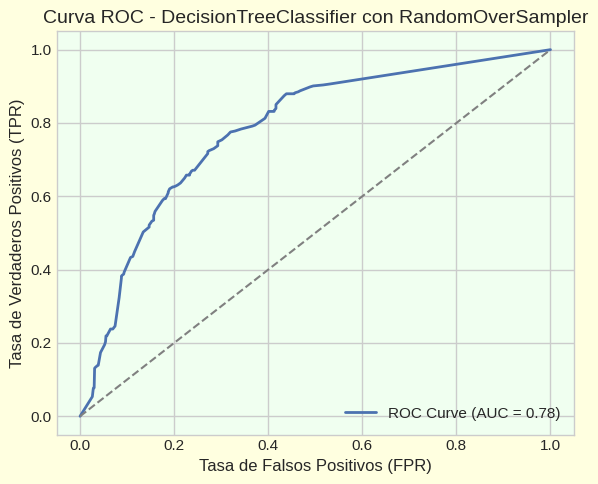

In [47]:
# mostramos curva ROC de pipeline
plot_roc_curve(pipeline, X_test, y_test, 'DecisionTreeClassifier con RandomOverSampler')



---


 <font color=red size=4>¿Qué representa?</font>



*   FPR (x): Proporción de negativos incorrectamente clasificados como positivos.
*   TPR (y): Proporción de positivos correctamente clasificados.
*   AUC (Area Under Curve): Cuanto más cerca de 1, mejor es el modelo.





---









###<font color=blue size=5> DecisionTreeClassifier optimización de parámetros</font>

In [48]:
# Cargamos datos
df = pd.read_csv("df_codificado.csv")
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Separamos en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Definimos pipeline con oversampling
pipeline_dt = imbpipeline(steps=[
    ("oversample", RandomOverSampler(random_state=42)),
    ("model", DecisionTreeClassifier(random_state=42))
])

# Definimos grilla de hiperparámetros
param_grid = {
    "model__max_depth": [None, 5, 10, 15, 20],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 4, 8],
    "model__criterion": ["gini", "entropy"]
}

# Scorer personalizado para recall de clase 1
recall_class1_scorer = make_scorer(recall_score, pos_label=1)

# Búsqueda de hiperparámetros
grid_search = GridSearchCV(
    pipeline_dt,
    param_grid,
    scoring=recall_class1_scorer,  # optimiza recall de clase 1
    n_jobs=-1,
    cv=3
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('oversample',
                                        RandomOverSampler(random_state=42)),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [None, 5, 10, 15, 20],
                         'model__min_samples_leaf': [1, 2, 4, 8],
                         'model__min_samples_split': [2, 5, 10, 20]},
             scoring=make_scorer(recall_score, response_method='predict', pos_label=1))

model__criterion: 	entropy
model__max_depth: 	5
model__min_samples_leaf: 	1
model__min_samples_split: 	2




              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1552
           1       0.49      0.80      0.61       561

    accuracy                           0.73      2113
   macro avg       0.70      0.75      0.70      2113
weighted avg       0.80      0.73      0.74      2113



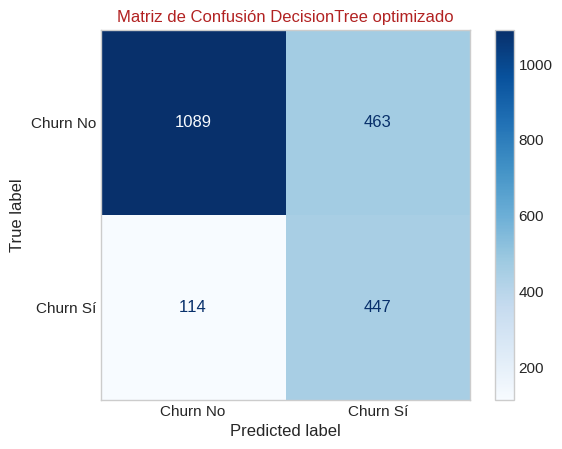

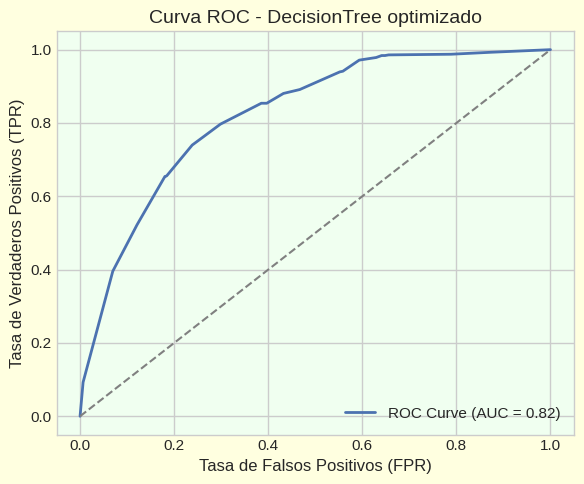

In [49]:
# imprimimos mejores parámetros
big_print("Mejores parámetros encontrados DecisionTree:",20,'brown')
for param, value in grid_search.best_params_.items():
    print(f"{param}: \t{value}")

# Evaluamos en test
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)

# guardamos métricas del modelo para informe fina
metricas_modelos.append(calcular_metricas('DecisionTree', y_test, y_pred))

# imprimimos reporte de clasificación
big_print("\nReporte de clasificación:",20,'brown')
print(classification_report(y_test, y_pred))

# mostramos matriz de confusión
plot_confusion_matrix(y_test, y_pred, 'DecisionTree optimizado')

# mostramos curva ROC
plot_roc_curve(best_pipeline, X_test, y_test, 'DecisionTree optimizado')

###<font color=blue size=5>Pipeline DecisionTreeClassifier optimizado</font>

In [50]:
# Definimos pipeline con los parámetros calculados previamente
pipeline_dt = grid_search.best_estimator_

# Entrenamos pipeline
pipeline_dt.fit(X_train, y_train)

# guardamos el pipeline optimizado
ruta_modelo = "pipeline_dt_optimizado.pkl"
joblib.dump(pipeline_dt, ruta_modelo)
big_print(f"Pipeline guardado en {ruta_modelo}",20)

# cargar el pipeline optimizado
pipeline_cargado = joblib.load(ruta_modelo)
big_print("Pipeline cargado correctamente.",20)

# ejecutamos el pipeline cargado en test
y_pred_cargado = pipeline_cargado.predict(X_test)

big_print("Reporte de clasificación usando el pipeline cargado:",20,'brown')
print(classification_report(y_test, y_pred_cargado))

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1552
           1       0.49      0.80      0.61       561

    accuracy                           0.73      2113
   macro avg       0.70      0.75      0.70      2113
weighted avg       0.80      0.73      0.74      2113



## <font color=blue size=5>CatBoost</font>

### <font color=blue size=5>CatBoost sin optimizaciones</font>

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



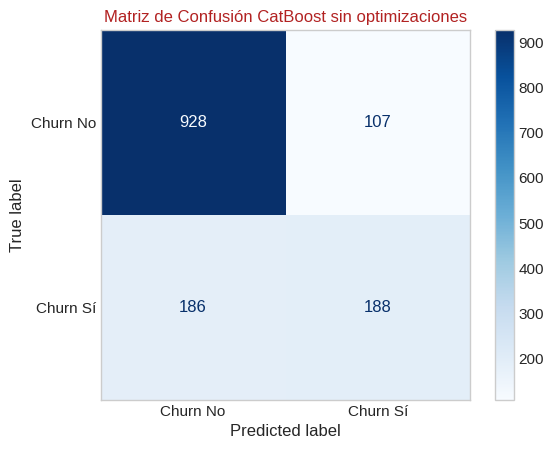

In [51]:
# Cargamos el dataset
df = pd.read_csv('df_codificado.csv')

# Separación de variables dependiente e independientes
X = df.drop('Churn', axis=1)
y = df['Churn']

# Separación en Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# creamos modelo CatBoost
modelo = CatBoostClassifier(random_state=42,max_depth=10, verbose=0)

# entrenamos con conjunto de train
modelo.fit(X_train, y_train, verbose=False)

# revisemos las métricas y la matriz de confusión
y_previsto = modelo.predict(X_test)

big_print("Reporte de Clasificación CatBoost sin optimizaciones", 20,'firebrick')
print(classification_report(y_test, y_previsto))

# mostramos matriz de confusión
plot_confusion_matrix(y_test, y_previsto, 'CatBoost sin optimizaciones')

###<font color=blue size=5> CatBosst con Validación cruzada</font>

Accuracy  : 0.788 ± 0.006
Precision : 0.625 ± 0.013
Recall    : 0.502 ± 0.028
F1        : 0.557 ± 0.020




              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



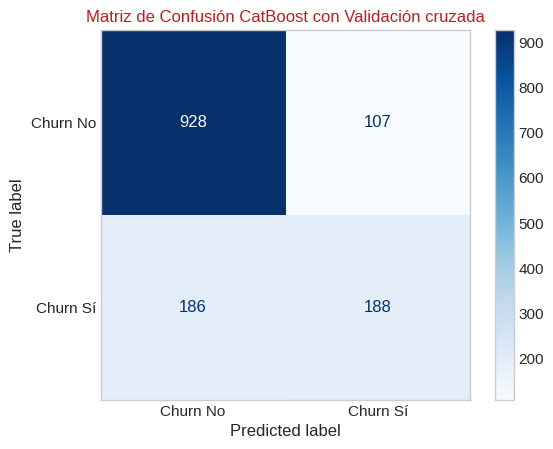

In [52]:
# Cargamos el dataset
df = pd.read_csv('df_codificado.csv')

# Separamos variables predictoras (X) y variable objetivo (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Separamos en conjunto de entrenamiento y prueba (stratify mantiene proporción de clases)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

# creamos modelo CatBoost
modelo = CatBoostClassifier(random_state=42,max_depth=10, verbose=0)

# Validación cruzada sobre el conjunto de entrenamiento
scoring = ['accuracy', 'precision', 'recall', 'f1']
cv_resultados = cross_validate(modelo, X_train, y_train, cv=5,
                               scoring=scoring, return_train_score=False)

# Mostramos resultados promedios de la validación cruzada
big_print("CatBoost con Validación cruzada",20,'brown')
for metrica in scoring:
    puntajes = cv_resultados[f'test_{metrica}']
    print(f"{metrica.capitalize():<10}: {puntajes.mean():.3f} ± {puntajes.std():.3f}")

# Entrenamos el modelo final con todos los datos de entrenamiento
modelo.fit(X_train, y_train, verbose=False)

# Predecimos con datos de test (jamás vistos por el modelo)
y_pred = modelo.predict(X_test)

# Reporte de clasificación
big_print("Reporte de Clasificación CatBoost con Validación Cruzada", 20,'firebrick')
print(classification_report(y_test, y_pred))

# mostramos matriz de confusión
plot_confusion_matrix(y_test, y_pred, 'CatBoost con Validación cruzada')

###<font color=blue size=5> CatBosst con balanceo de clases</font>



---


Probaremos dos técnicas


*   auto_class_weights='Balanced'
*   weight_ratio = n_class0 / n_class1




---


<font color=red size=4>Balanceo con auto_class_weights='Balanced'</font>

              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1035
           1       0.55      0.63      0.58       374

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.78      0.76      0.77      1409



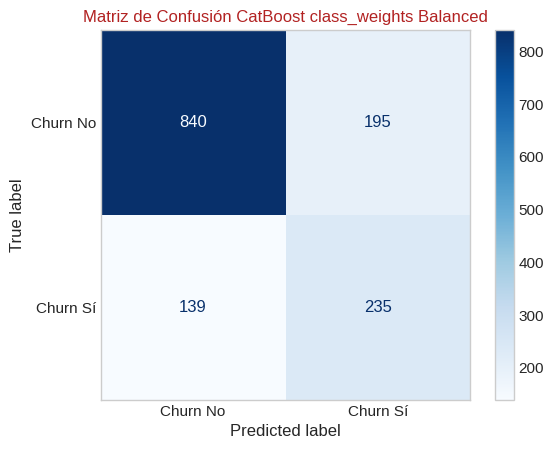

In [53]:
# Cargamos el dataset
df = pd.read_csv('df_codificado.csv')

# Separación de variables dependiente e independientes
X = df.drop('Churn', axis=1)
y = df['Churn']

# Separación en Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# creamos modelo CatBoost con balanceo de clases
modelo = CatBoostClassifier(random_state=42,max_depth=10,
                          auto_class_weights='Balanced',
                          verbose=0)

# entrenamos con conjunto de train
modelo.fit(X_train, y_train, verbose=False)

# revisemos las métricas y la matriz de confusión
y_previsto = modelo.predict(X_test)

big_print("Reporte de Clasificación CatBoost class_weights Balanced", 20,'firebrick')
print(classification_report(y_test, y_previsto))

# mostramos matriz de confusión
plot_confusion_matrix(y_test, y_previsto, 'CatBoost class_weights Balanced')



---


<font color=red size=4>Balanceo con weight_ratio = n_class0 / n_class1</font>

              precision    recall  f1-score   support

           0       0.92      0.70      0.80      1035
           1       0.50      0.82      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.81      0.74      0.75      1409



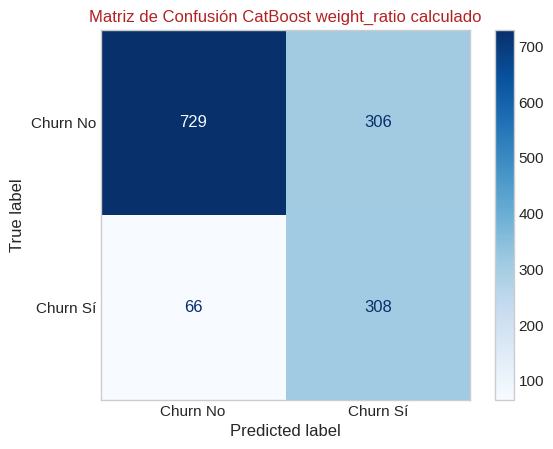

In [54]:
# Cargamos el dataset
df = pd.read_csv('df_codificado.csv')

# Separación de variables dependiente e independientes
X = df.drop('Churn', axis=1)
y = df['Churn']

# Separación en Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# creamos modelo CatBoost con balanceo de clases definido según ratio de clases
# Calculamos ratio exacto
n_class0 = sum(y_train == 0)
n_class1 = sum(y_train == 1)
weight_ratio = n_class0 / n_class1

modelo = CatBoostClassifier(
    class_weights=[1, weight_ratio],
    iterations=1000,
    early_stopping_rounds=50,
    eval_metric='Recall',
    random_state=42,
    verbose=0
)

modelo.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    use_best_model=True,
    verbose=False
)

# revisemos las métricas y la matriz de confusión
y_previsto = modelo.predict(X_test)

big_print("Reporte de Clasificación CatBoost weight_ratio calculado", 20,'firebrick')
print(classification_report(y_test, y_previsto))

# mostramos matriz de confusión
plot_confusion_matrix(y_test, y_previsto, 'CatBoost weight_ratio calculado')

<font color=red size=4>El balanceo utilizando weight_ratio = n_class0 / n_class1 tiene resultados mucho mejores que utilizando auto_class_weights='Balanced'</font>


---



###<font color=blue size=5>CatBoost optimización de parámetros</font>





---


<font color=red size=4>Búsqueda Aleatoria (RandomizedSearchCV)</font>

In [55]:
param_dist = {
    'depth': np.arange(4, 11),
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15],
    'l2_leaf_reg': np.logspace(-2, 2, 10),
    'border_count': [32, 64, 128, 256],
    'min_data_in_leaf': [1, 5, 10, 20],
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']
}

modelo = CatBoostClassifier(
    class_weights=[1, weight_ratio],
    iterations=1000,
    early_stopping_rounds=50,
    random_state=42,
    verbose=0
)

search = RandomizedSearchCV(
    modelo,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train, eval_set=[(X_test, y_test)])

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7dedd0ab8950>,
                   n_iter=50, n_jobs=-1,
                   param_distributions={'border_count': [32, 64, 128, 256],
                                        'depth': array([ 4,  5,  6,  7,  8,  9, 10]),
                                        'grow_policy': ['SymmetricTree',
                                                        'Depthwise',
                                                        'Lossguide'],
                                        'l2_leaf_reg': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                                        'learning_rate': [0.01, 0.03, 0.05, 0.1,
                                                          0.15],
                                        'min_data_in_leaf': [1, 5, 10, 20]},
                   random_state=42, scoring='recall')

min_data_in_leaf: 1
learning_rate: 0.1
l2_leaf_reg: 100.0
grow_policy: Depthwise
depth: 4
border_count: 128




              precision    recall  f1-score   support

           0       0.91      0.74      0.81      1035
           1       0.52      0.81      0.64       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.75      0.77      1409



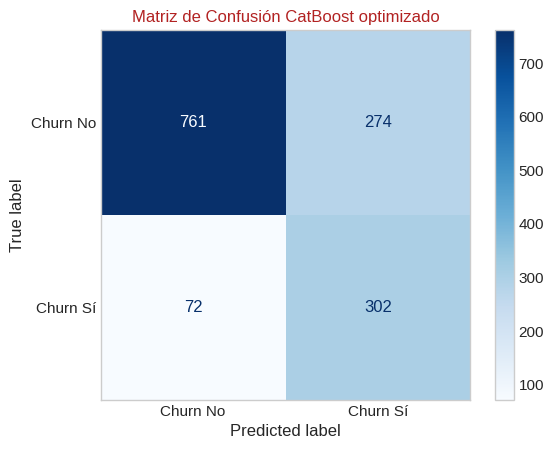

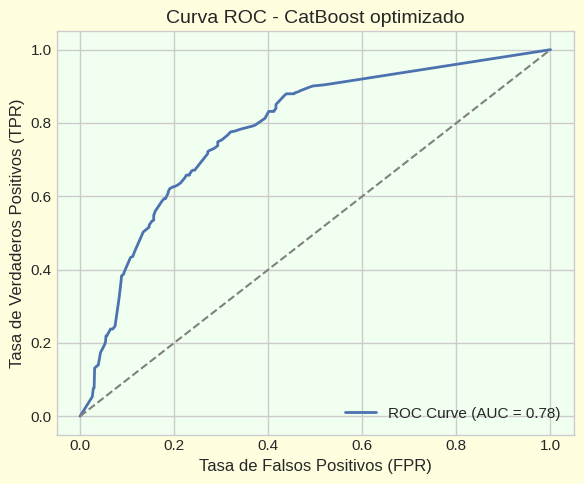

In [56]:
big_print("Mejores parámetros encontrados para CaatBoost:",20,'brown')

# imprimimos mejores parámetros
for param, value in search.best_params_.items():
    print(f"{param}: {value}")

# Evaluar en test
mejor_modelo = search.best_estimator_
y_pred = mejor_modelo.predict(X_test)

# guardamos métricas para informe final
metricas_modelos.append(calcular_metricas('CatBoost', y_test, y_pred))

# reporte de clasificación
big_print("Reporte de clasificación CatBoost optimizado",20,'brown')
print(classification_report(y_test, y_pred))

# mostramos matriz de confusión
plot_confusion_matrix(y_test, y_pred, 'CatBoost optimizado')

# mostramos curva ROC de pipeline
plot_roc_curve(pipeline, X_test, y_test, 'CatBoost optimizado')

###<font color=blue size=5>Pipeline CatBoost optimizado</font>

In [57]:
# Definimos pipeline con los parámetros calculados previamente
pipeline_cb = search.best_estimator_

# Entrenamos pipeline
pipeline_cb.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# guardamos el pipeline optimizado usando try para manejo de error


ruta_modelo = "pipeline_CatBoost_optimizado.pkl"
joblib.dump(pipeline_cb, ruta_modelo)
big_print(f"Pipeline guardado en {ruta_modelo}",20,'brown')

# cargar el pipeline optimizado
pipeline_cargado = joblib.load(ruta_modelo)
big_print("Pipeline cargado correctamente.",20,'brown')

# ejecutamos el pipeline cargado en test
y_pred_cargado = pipeline_cargado.predict(X_test)

big_print("Reporte de clasificación usando el pipeline cargado:",20,'brown')
print(classification_report(y_test, y_pred_cargado))

              precision    recall  f1-score   support

           0       0.91      0.74      0.81      1035
           1       0.52      0.81      0.64       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.75      0.77      1409



## <font color=blue size=5>RandomForestClassifier</font>

### <font color=blue size=5>RandomForestClassifier sin optimizaciones</font>

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.48      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409



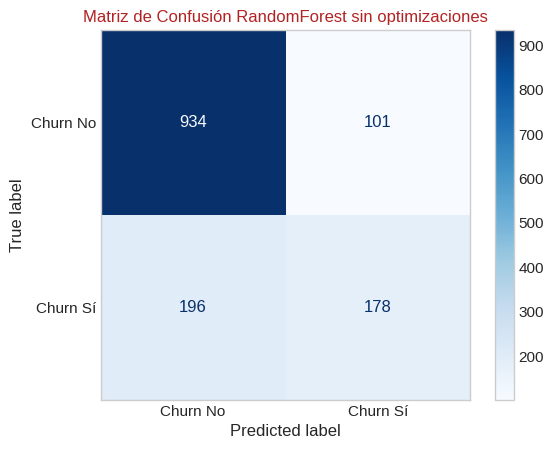

In [58]:
# Cargamos el dataset
df = pd.read_csv('df_codificado.csv')

# Separación de variables dependiente e independientes
X = df.drop('Churn', axis=1)
y = df['Churn']

# Separación en Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# creamos modelo RandomForestClassifier
modelo = RandomForestClassifier(random_state=42,max_depth=10)

# entrenamos con conjunto de train
modelo.fit(X_train, y_train)

# revisemos las métricas y la matriz de confusión
y_previsto = modelo.predict(X_test)

big_print("Reporte de Clasificación RandomForest sin optimizaciones", 20,'firebrick')
print(classification_report(y_test, y_previsto))

#mostramos matriz de confusión
plot_confusion_matrix(y_test, y_previsto, 'RandomForest sin optimizaciones')

<font color=red size=4>
¿Qué significa esta matriz de confusión?</font>

1. que predijo correctamente 933 Churn No (Verdaderos Negativos TN) **90%**

2. que predijo erróneamente 102 Churn No como Churn Sí (Falsos Positivos FP)

3. predijo correctamente 195 Churn Sí (Verdaderos Positivos TP) **48%**

4. predijo erróneamente 179 Churn Sí como Churn No (Falsos Negativos FN)

Al igual que con DecisionTreeClassifier, este modelo es prácticamente inútil para predecir correctamente los Churn Sí ya que solo identifica correctamente al 48% de ellos a pesar de que identifica correctamente a casi al 90% de los Churn No.

Este modelo no es útil porque nuestro objetivo es identificar lo mejor posible los clientes con Churn Sí.

**Nuestro objetivo es encontrar un modelo donde el recall para Churn Sí sea el mayor posible.**


---



###<font color=blue size=5> RandomForestClassifier con Validación cruzada</font>

Accuracy  : 0.805 ± 0.010
Precision : 0.674 ± 0.023
Recall    : 0.515 ± 0.027
F1        : 0.584 ± 0.024




              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.48      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409



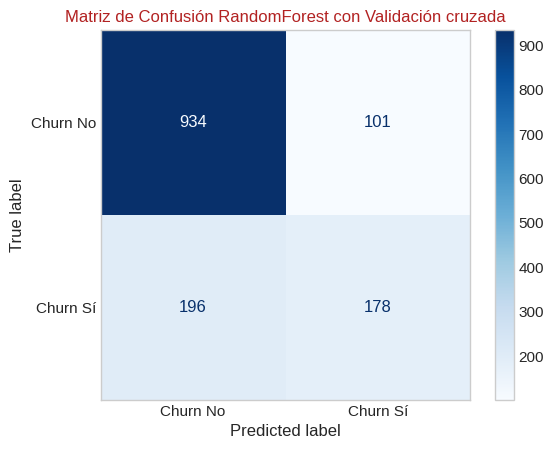

In [59]:
# Cargamos el dataset
df = pd.read_csv('df_codificado.csv')

# Separamos variables predictoras (X) y variable objetivo (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Separamos en conjunto de entrenamiento y prueba (stratify mantiene proporción de clases)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

# Creamos modelo RandomForest
modelo = RandomForestClassifier(random_state=42, max_depth=10)

# Validación cruzada sobre el conjunto de entrenamiento
scoring = ['accuracy', 'precision', 'recall', 'f1']
cv_resultados = cross_validate(modelo, X_train, y_train, cv=5,
                               scoring=scoring, return_train_score=False)

# Mostramos resultados promedios de la validación cruzada
big_print("RandomForest con Validación cruzada",20,'brown')
for metrica in scoring:
    puntajes = cv_resultados[f'test_{metrica}']
    print(f"{metrica.capitalize():<10}: {puntajes.mean():.3f} ± {puntajes.std():.3f}")

# Entrenamos el modelo final con todos los datos de entrenamiento
modelo.fit(X_train, y_train)

# Predecimos con datos de test (jamás vistos por el modelo)
y_pred = modelo.predict(X_test)

# Reporte de clasificación
big_print("Reporte de Clasificación RandomForest con Validación Cruzada", 20,'firebrick')
print(classification_report(y_test, y_pred))

# mostramos matriz de confusión
plot_confusion_matrix(y_test, y_pred, 'RandomForest con Validación cruzada')

<font color=red size=4>
¿Qué significa esta matriz de confusión de RandomForest con validación cruzada?</font>

1. que predijo correctamente 933 Churn No (Verdaderos Negativos TN) **90%**

2. que predijo erróneamente 102 Churn No como Churn Sí (Falsos Positivos FP)

3. predijo correctamente 179 Churn Sí (Verdaderos Positivos TP) **48%**

4. predijo erróneamente 195 Churn Sí como Churn No (Falsos Negativos FN)


<font color=red size=4>
¿Qué significan las métricas obtenidas con la validación cruzada?</font>



1.   **RandomForestClassifier** entrenado con validación cruzada (CV) muestra las mismas métricas que el modelo entrenado sin CV (usando un solo train-test split), esto nos indica:

  - Estabilidad del modelo: El modelo es robusto ante diferentes particiones de datos.

  - No es sensible a variaciones aleatorias en la división entrenamiento/prueba.

2. Calidad de los datos: Los datos están bien distribuidos y no hay sesgos fuertes o patrones ocultos que afecten el rendimiento según cómo se dividan.

3. El tamaño del dataset es adecuado (no es demasiado pequeño), lo que reduce la variabilidad en las métricas entre diferentes splits.

4. Ausencia de overfitting significativo
El modelo generaliza bien: su rendimiento en datos no vistos es consistente, independientemente de cómo se evalúe (CV vs. holdout simple).

###<font color=blue size=5> RandomForestClassifier con balanceo de clases</font>



---


<font color=red size=4>Probaremos las mismas cuatro técnicas de balanceo que probamos con DecisionTreeClassifier más la opción propia de RandomFores classweight</font>


*   RandomOverSampler
*   SMOTE
*   ADASYN
*   TomekLinks
*   classweight = 'balanced'



---






              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1035
           1       0.54      0.74      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409



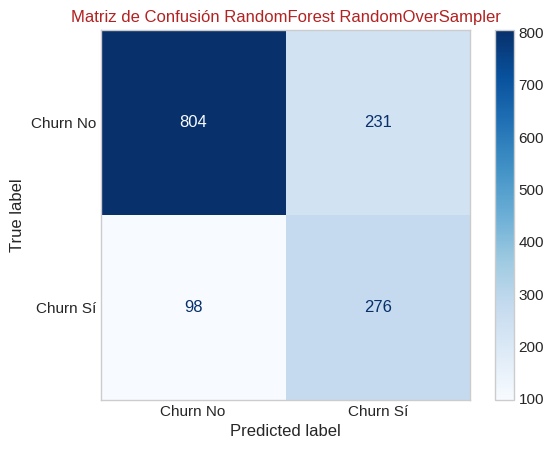

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1035
           1       0.57      0.63      0.60       374

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.72      1409
weighted avg       0.78      0.78      0.78      1409



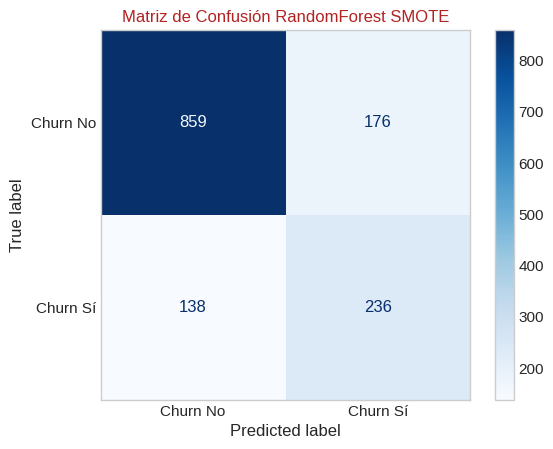

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1035
           1       0.58      0.65      0.61       374

    accuracy                           0.78      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.79      0.78      0.78      1409



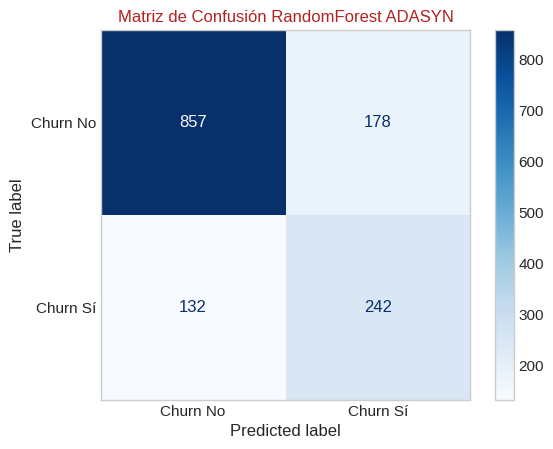

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1035
           1       0.61      0.57      0.59       374

    accuracy                           0.79      1409
   macro avg       0.73      0.72      0.72      1409
weighted avg       0.78      0.79      0.79      1409



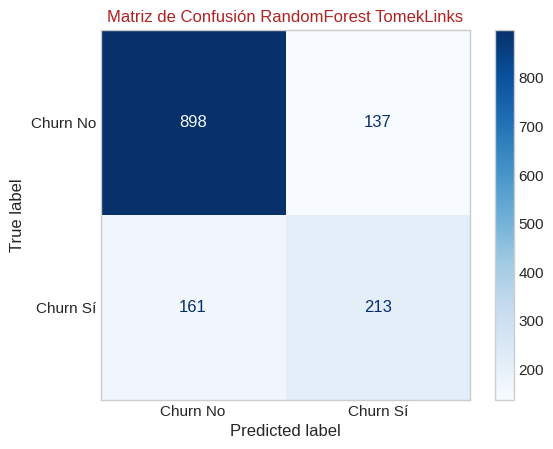

              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1035
           1       0.56      0.74      0.64       374

    accuracy                           0.78      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.80      0.78      0.79      1409



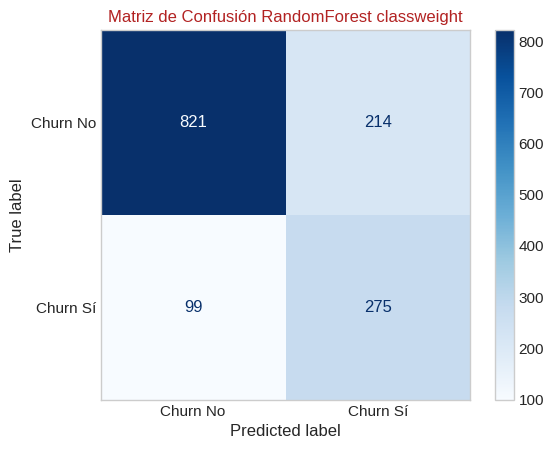

             Técnica  Accuracy  Precision    Recall  F1-score
0  RandomOverSampler  0.766501   0.544379  0.737968  0.626561
4        classweight  0.777857   0.562372  0.735294  0.637312
2             ADASYN  0.779986   0.576190  0.647059  0.609572
1              SMOTE  0.777147   0.572816  0.631016  0.600509
3         TomekLinks  0.788502   0.608571  0.569519  0.588398


In [60]:
# Cargamos datos
df = pd.read_csv("df_codificado.csv")

# Separamos variables
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Separamos en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Diccionario con técnicas de muestreo
samplers = {
    "RandomOverSampler": RandomOverSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
    "TomekLinks": TomekLinks(),
    "classweight": "balanced"
}

# Almacenar resultados
resultados = []

# Entrenamiento y evaluación por técnica
def entrenar_y_evaluar(X_res, y_res, nombre):
    if nombre == "classweight":
        modelo = RandomForestClassifier(max_depth=10, class_weight='balanced', random_state=42)
    else:
      modelo = RandomForestClassifier(max_depth=10, random_state=42)

    modelo.fit(X_res, y_res)
    y_pred = modelo.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    resultados.append({
        "Técnica": nombre,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    })

    big_print(f"===== {nombre} =====",20,'brown')
    print(classification_report(y_test, y_pred))

    # mostramos matriz de confución
    plot_confusion_matrix(y_test, y_pred, f"RandomForest {nombre}")

# Ejecutar para cada técnica
for nombre, sampler in samplers.items():
    try:
        if nombre == "classweight":
          X_res, y_res = (X_train, y_train)
        else:
          X_res, y_res = sampler.fit_resample(X_train, y_train)
        entrenar_y_evaluar(X_res, y_res, nombre)
    except Exception as e:
        print(f"Error en {nombre}: {e}")

# Mostrar tabla comparativa
df_resultados = pd.DataFrame(resultados)
big_print("📊 Métricas RandomForest por Técnica de Balanceo:",20,'brown')
print(df_resultados.sort_values("Recall", ascending=False))


<font color=red size=5>Graficamos Recall y F1 para las cinco técnicas de balanceo</font>

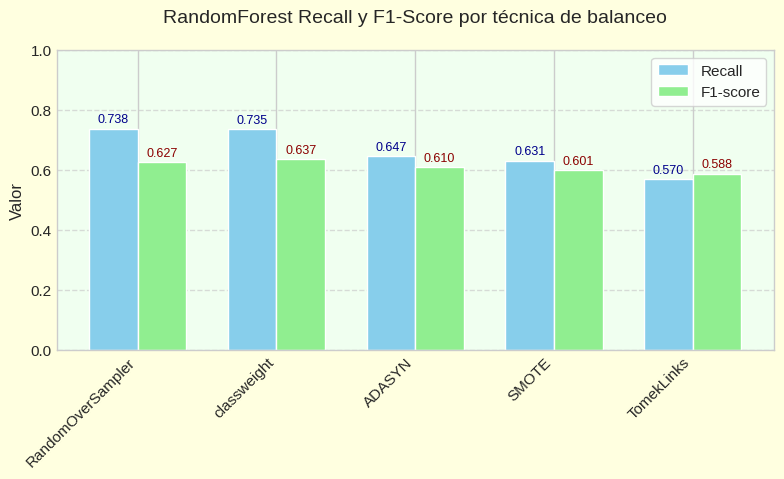

In [61]:
# Ordenar el DataFrame por Recall de mayor a menor
df_sorted = df_resultados.sort_values('Recall', ascending=False)

# Configuración del gráfico
plt.figure(figsize=(8, 4), facecolor='lightyellow')
ax = plt.gca()
ax.set_facecolor('honeydew')

# Configuración de barras
n = len(df_sorted)
bar_width = 0.35
index = np.arange(n)

# Creamos barras para Recall y F1-score
plt.bar(index - bar_width/2, df_sorted['Recall'], bar_width,
        color='skyblue', label='Recall')
plt.bar(index + bar_width/2, df_sorted['F1-score'], bar_width,
        color='lightgreen', label='F1-score')

# Añadimos valores en las barras
for i, (rec, f1) in enumerate(zip(df_sorted['Recall'], df_sorted['F1-score'])):
    plt.text(i - bar_width/2, rec + 0.02, f"{rec:.3f}",
             ha='center', fontsize=9, color='darkblue')
    plt.text(i + bar_width/2, f1 + 0.02, f"{f1:.3f}",
             ha='center', fontsize=9, color='darkred')

# Personalización del gráfico
plt.title('RandomForest Recall y F1-Score por técnica de balanceo', pad=20, fontsize=14)
plt.ylabel('Valor')
plt.ylim(0, 1)
plt.xticks(index, df_sorted['Técnica'], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(frameon=True, loc='best')

# Mejorar espaciado
plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.15)
# guardamos gráfico como archivo png
plt.savefig('graf_RF_recall_por_tecnica_balaceo.png', dpi=300, bbox_inches='tight')
plt.show()

<font color=red size=5>Intervalo de confianza del Recall</font>

In [62]:
# revisemos el intervalo de confianza para el modelo balanceado con RandomOverSampler
# Cargamos el dataset
df = pd.read_csv('df_codificado.csv')

# Separamos variables predictoras y objetivo
X = df.drop('Churn', axis=1)
y = df['Churn']

# Creamos pipeline con RandomOverSampler + modelo
pipeline = imbpipeline([
    ('oversample', RandomOverSampler(random_state=42)),
    ('modelo', RandomForestClassifier(random_state=42, max_depth=10))
])

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Métrica que quieremos evaluar 'recall'
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='recall')

# Calcular media y desviación estándar
mean_score = np.mean(scores)
std_score = np.std(scores)

# Calcular intervalo de confianza 95%
confidence = 0.95
z = stats.norm.ppf(1 - (1 - confidence)/2)
margin_error = z * std_score / np.sqrt(len(scores))
lower = mean_score - margin_error
upper = mean_score + margin_error

# Mostrar resultados
big_print(f"Recall promedio: {mean_score:.4f}",20,'red')
big_print(f"Intervalo de confianza del 95%: ({lower:.4f}, {upper:.4f})",20,'red')


<font color=red size=5>Curva ROC para RandomForestClassifier</font>

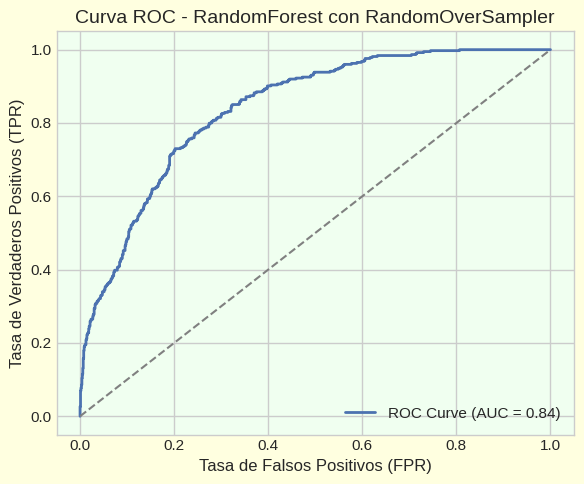

In [63]:
# mostramos curba ROC con el pipeline
titulo = "RandomForest con RandomOverSampler"
plot_roc_curve(pipeline, X_test, y_test,titulo)



---


 <font color=red size=4>¿Qué representa?</font>



*   FPR (x): Proporción de negativos incorrectamente clasificados como positivos.
*   TPR (y): Proporción de positivos correctamente clasificados.
*   AUC (Area Under Curve): Cuanto más cerca de 1, mejor es el modelo.





---









###<font color=blue size=5>RandomForest  Optimización de parámetros</font>

In [64]:
# Cargar los datos
df = pd.read_csv("df_codificado.csv")
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Separar en Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Pipeline con balanceo y modelo
pipeline = imbpipeline([
    ('oversample', RandomOverSampler(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])

# Hiperparámetros a optimizar
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]
}

# Scoring personalizado: solo el recall de la clase positiva
recall_pos_scorer = make_scorer(recall_score, pos_label=1)

# Búsqueda aleatoria de parámetros
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=30,
    cv=5,
    scoring=recall_pos_scorer,  # Enfocado en recall clase 1
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Entrenamiento
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('oversample',
                                              RandomOverSampler(random_state=42)),
                                             ('clf',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'clf__class_weight': ['balanced',
                                                              {0: 1, 1: 2},
                                                              {0: 1, 1: 3}],
                                        'clf__max_depth': [None, 10, 20, 30],
                                        'clf__max_features': ['sqrt', 'log2'],
                                        'clf__min_samples_leaf': [1, 2, 4],
                                        'clf__min_samples_split': [2, 5, 10],
                                        'clf__n_estimators': [100, 200, 300]},
                   random_state=42,
                   scoring=make_scorer(recall_score, response_method='predict', pos_label=1),
                   verbose=2)

clf__n_estimators: 	200
clf__min_samples_split: 	2
clf__min_samples_leaf: 	4
clf__max_features: 	log2
clf__max_depth: 	10
clf__class_weight: 	{0: 1, 1: 3}




              precision    recall  f1-score   support

           0       0.94      0.61      0.74      1035
           1       0.45      0.89      0.60       374

    accuracy                           0.68      1409
   macro avg       0.69      0.75      0.67      1409
weighted avg       0.81      0.68      0.70      1409



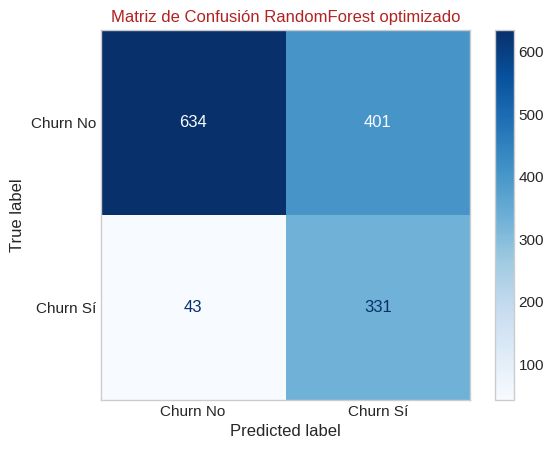

In [65]:
big_print("Mejores parámetros encontrados para RandomForest:",20,'brown')

# imprimimos mejores parámetros
for param, value in random_search.best_params_.items():
    print(f"{param}: \t{value}")

# Evaluar en test
mejor_modelo = random_search.best_estimator_
y_pred = mejor_modelo.predict(X_test)

# guardamos métricas para informe final
metricas_modelos.append(calcular_metricas('RandomForest', y_test, y_pred))

big_print("Reporte de clasificación RandomForest optimizado",20,'brown')
print(classification_report(y_test, y_pred))

# desplegamos matriz de confusión
plot_confusion_matrix(y_test, y_pred, 'RandomForest optimizado')

<font color=blue size=5>Intervalo de confianza de Recall para RandomForest optimizado</font>

In [66]:
# Mejor modelo ya entrenado
mejor_modelo = random_search.best_estimator_

# Número de repeticiones del bootstrap
n_iterations = 1000
recalls = []

# Probabilidades para fijar la semilla y asegurar reproducibilidad
rng = np.random.default_rng(seed=42)

# Bootstrap sobre los datos de test
for _ in range(n_iterations):
    # Re-muestreo con reemplazo
    indices = rng.integers(0, len(X_test), len(X_test))
    X_resampled = X_test.iloc[indices]
    y_resampled = y_test.iloc[indices]

    # Predicción
    y_pred = mejor_modelo.predict(X_resampled)

    # Calcular recall clase 1
    recalls.append(recall_score(y_resampled, y_pred, pos_label=1))

# Intervalo de confianza al 95%
lower = np.percentile(recalls, 2.5)
upper = np.percentile(recalls, 97.5)

big_print(f"Recall medio (clase 1): {np.mean(recalls):.3f}",20,'brown')
big_print(f"IC 95% para Recall clase 1: ({lower:.3f}, {upper:.3f})",20,'brown')


<font color=red size=5>Curva ROC para DecisionTreeClassifier optimizado</font>

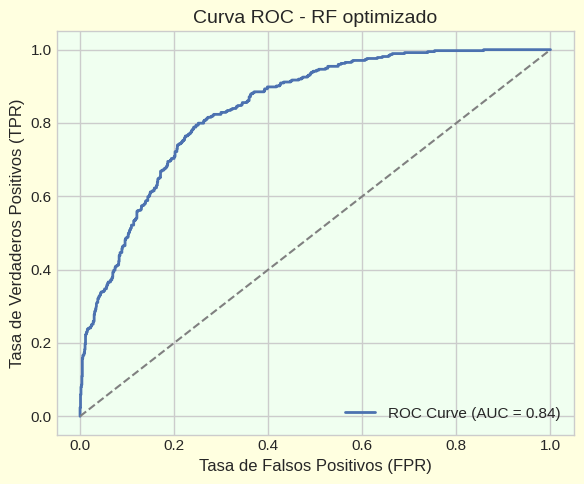

In [67]:
# Mejor modelo optimizado encontrado por RandomizedSearchCV
mejor_modelo = random_search.best_estimator_

# desplegamos curva ROC
titulo = "RF optimizado"
plot_roc_curve(mejor_modelo, X_test, y_test,titulo)

### <font color=blue size=5>Pipeline RandomForest optimizado</font>



---
<font color=red size=4>
El modelo RandomForestClassifier optimizado predijo correctamente al 90% de los Churn Sí.

Predijo correctamente al 61% de los Churn No.</font>


<font color=red size=4>
Este es un modelo aceptable</font>

---



In [68]:
# Parámetros optimizados que obtuvimos con RandomizedSearchCV

parametros_optimizados = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'bootstrap': True,
    'class_weight': {0: 1, 1: 3},
    'random_state': 42
}

modelo_optimizado = RandomForestClassifier(**parametros_optimizados)
modelo_optimizado.fit(X_train, y_train)

# Creamos el pipeline
pipeline_optimizado = imbpipeline(steps=[
    ('oversample', RandomOverSampler(random_state=42)),
    ('rf', RandomForestClassifier(**parametros_optimizados))
])

# Entrenamos el pipeline en los datos de entrenamiento
pipeline_optimizado.fit(X_train, y_train)

# Evaluamos en el conjunto de prueba
y_pred = pipeline_optimizado.predict(X_test)

# guardamos el pipeline optimizado
ruta_modelo = "pipeline_RandomForest_optimizado.pkl"
joblib.dump(pipeline_optimizado, ruta_modelo)
big_print(f"Pipeline guardado en {ruta_modelo}",20,'brown')

# cargamos pipeline optimizado
pipeline_cargado = joblib.load(ruta_modelo)
big_print("Pipeline cargado correctamente.",20,'brown')

# ejecutamos pipeline sobre test
y_pred_cargado = pipeline_cargado.predict(X_test)

big_print("Reporte de clasificación usando el pipeline cargado:",20,'brown')
print(classification_report(y_test, y_pred_cargado))

              precision    recall  f1-score   support

           0       0.94      0.61      0.74      1035
           1       0.45      0.89      0.60       374

    accuracy                           0.69      1409
   macro avg       0.70      0.75      0.67      1409
weighted avg       0.81      0.69      0.70      1409



### <font color=blue size=5>Feature importance</font>

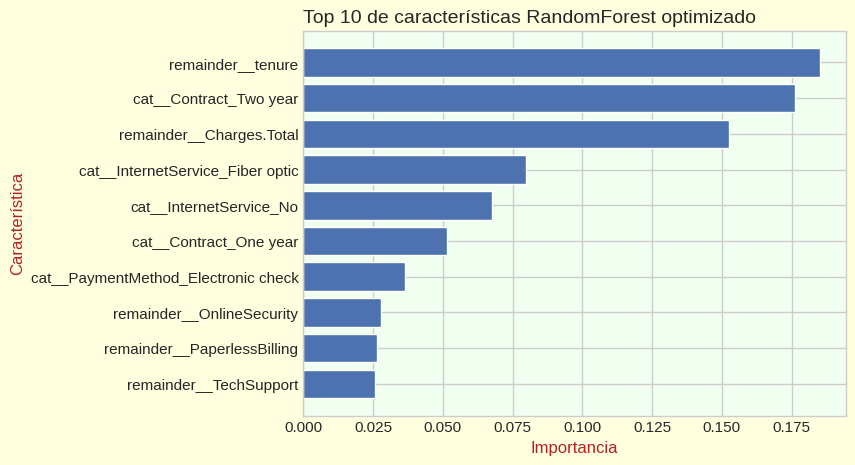

In [69]:
# Accedemos al modelo dentro del pipeline usando su nombre ('rf')
modelo_final = pipeline_optimizado.named_steps['rf']

# Extraemos las importancias del modelo
importancias = modelo_final.feature_importances_

# Creamos un DataFrame para visualización
df_importancias = pd.DataFrame({
    'Característica': X_train.columns,
    'Importancia': importancias
})

# Ordenamos de mayor a menor importancia
df_importancias = df_importancias.sort_values('Importancia', ascending=True)

# seleccionamos solo las características con una importancia mayor al 1%
df_importancias = df_importancias[df_importancias['Importancia'] > 0.02]

# Mostrar las 10 características más importantes
# print(df_importancias.head(10))

# graficamos importancias en barras horizontales en orden descendentes
plt.figure(figsize=(7, 5), facecolor='lightyellow')
ax = plt.gca()
ax.set_facecolor('honeydew')
plt.title('Top 10 de características RandomForest optimizado', fontsize=14, loc='left')
plt.xlabel('Importancia', color='firebrick', fontsize=12)
plt.ylabel('Característica', color='firebrick', fontsize=12)

plt.barh(df_importancias['Característica'], df_importancias['Importancia'])

# guardamos gráfico como archivo png
plt.savefig('graf_RF_importancias.png', dpi=300, bbox_inches='tight')
plt.show()

## <font color=blue size=5>Resumen de métricas de modelos</font>

In [70]:
# Crear DataFrame
metricas_df = pd.DataFrame(metricas_modelos)

# Formatear las métricas para mejor visualización
metricas_df_formateado = metricas_df.copy()
for col in ['Accuracy', 'Precision_Clase_1', 'Recall_Clase_1', 'F1-Score_Clase_1']:
    metricas_df_formateado[col] = metricas_df_formateado[col].map('{:.2%}'.format)

# definimos 'Modelo' como index
metricas_df_formateado.set_index('Modelo', inplace=True)
# Mostrar tabla comparativa
big_print("Tabla Comparativa de Modelos:",20,'brown')
display(metricas_df_formateado)

,Accuracy,Precision_Clase_1,Recall_Clase_1,F1-Score_Clase_1
Modelo,,,,
DecisionTree,72.69%,49.12%,79.68%,60.77%
CatBoost,75.44%,52.43%,80.75%,63.58%
RandomForest,68.49%,45.22%,88.50%,59.86%


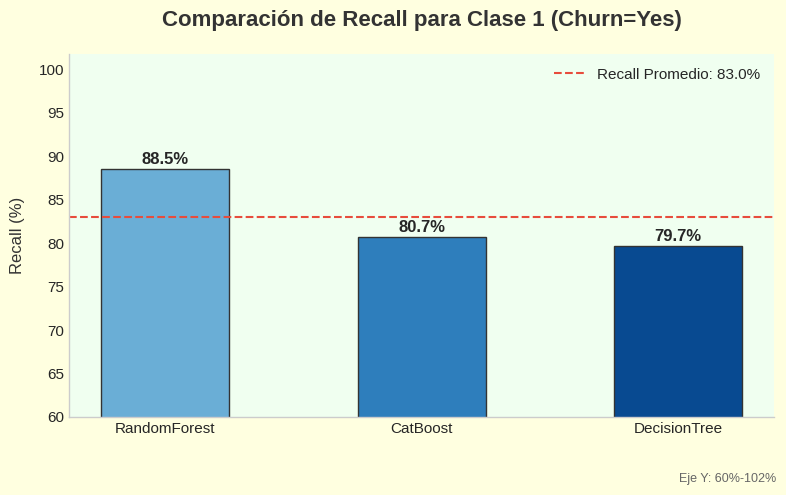

In [71]:
# Ordenar por Recall para mejor visualización
metricas_df = metricas_df.sort_values('Recall_Clase_1', ascending=False)

# Configuración del gráfico
plt.figure(figsize=(8, 5), facecolor='lightyellow')
ax = plt.subplot(facecolor='honeydew')

# Crear colores con gradiente
colors = plt.cm.Blues(np.linspace(0.5, 0.9, len(metricas_df)))

# Crear gráfico de barras
bars = ax.bar(metricas_df['Modelo'],
              metricas_df['Recall_Clase_1'] * 100,
              color=colors,
              edgecolor='#333333',
              width=0.5)

# Añadir valores en las barras
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.,
            height + 0.2,  # Ajuste menor de posición
            f'{height:.1f}%',
            ha='center',
            va='bottom',
            fontsize=12,
            fontweight='bold')

# Personalización
plt.title('Comparación de Recall para Clase 1 (Churn=Yes)',
          fontsize=16, pad=20, fontweight='bold', color='#333333')
plt.xlabel('')
plt.ylabel('Recall (%)', fontsize=12, labelpad=10, color='#333333')

# AJUSTE PRINCIPAL: Eje Y comienza en 60%
y_min = 60
y_max = metricas_df['Recall_Clase_1'].max() * 100 * 1.15  # 15% más de espacio arriba
plt.ylim(y_min, y_max)

# Añadir línea de referencia
avg_recall = metricas_df['Recall_Clase_1'].mean() * 100
plt.axhline(y=avg_recall,
            color='#e74c3c',
            linestyle='--',
            linewidth=1.5,
            label=f'Recall Promedio: {avg_recall:.1f}%')

# Decoración
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#cccccc')
ax.spines['bottom'].set_color('#cccccc')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='upper right')

# Añadir anotación sobre la escala
plt.figtext(0.98, 0.02,
            f"Eje Y: {y_min}%-{y_max:.0f}%",
            ha='right', fontsize=9, color='#666666')
plt.grid(False)
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Más espacio abajo

# guardamos gráfico como archivo png
plt.savefig('graf_recall_por_modelo.png', dpi=300, bbox_inches='tight')
plt.show()

## <font color=blue size=5>Pipeline completo de Random Forest con preprocesamiento</font>

<font color=red size=4>Este Pipeline se creará para recibir los datos en su formato original, e incluirá todas las transformaciones realizadas para crear el modelo.</font>

In [72]:
# Leemos archivo /content/df_normalizado.csv
df = pd.read_csv('/content/df_normalizado.csv')

# Separamos las variables dependiente e independientes
X = df.drop('Churn', axis=1)
y = df['Churn']

# Dividimos train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [73]:
# Transformador para eliminar columnas
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
        self.columns_ = None  # Inicializamos como None

    def fit(self, X, y=None):
        # Identificar las columnas que existen y queremos eliminar
        self.columns_ = [col for col in self.columns_to_drop if col in X.columns]
        return self

    def transform(self, X):
        # Si no se ha llamado a fit, intentamos determinar las columnas
        if self.columns_ is None:
            self.columns_ = [col for col in self.columns_to_drop if col in X.columns]
        return X.drop(columns=self.columns_, errors='ignore')

# Transformador para valores "Yes"
class YesToBinaryTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns_to_transform = []  # Inicializamos como lista vacía

    def fit(self, X, y=None):
        # Identificar columnas que contienen 'Yes'
        for col in X.columns:
            if X[col].dtype == 'object':
                unique_vals = X[col].dropna().unique()
                if 'Yes' in unique_vals:
                    self.columns_to_transform.append(col)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns_to_transform:
            if col in X_copy.columns:
                X_copy[col] = X_copy[col].apply(lambda x: 1 if str(x) == 'Yes' else 0)
        return X_copy

# Parámetros optimizados
parametros_optimizados = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'bootstrap': True,
    'class_weight': {'No': 1, 'Yes': 3},
    'random_state': 42
}

# Columnas para one-hot encoding
categorical_cols = ['gender', 'InternetService', 'Contract', 'PaymentMethod']

# Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)

In [74]:
# Creamos pipeline de entrenamiento con todo el preprocesamiento
pipeline_entrenamiento = imbpipeline(steps=[
    ('drop_columns', ColumnDropper(columns_to_drop=['customerID', 'Charges.Monthly'])),
    ('yes_to_binary', YesToBinaryTransformer()),
    ('preprocessor', preprocessor),
    ('oversample', RandomOverSampler(random_state=42)),
    ('rf', RandomForestClassifier(**parametros_optimizados))
])

# Entrenamos el pipeline con todos los datos porque ya no necesitamos nuevas validaciones de test
pipeline_entrenamiento.fit(X, y)

# Guardamos el pipeline entrenado
ruta_modelo = "pipeline_final_RandomForest_entrenamiento.pkl"
joblib.dump(pipeline_entrenamiento, ruta_modelo)
big_print("Pipeline final RandomForest de entrenamiento guardado.",20,'brown')

# Creamos pipeline de producción a partir del pipeline de entrenamiento
# Cargamos el pipeline entrenado
pipeline_cargado = joblib.load(ruta_modelo)
big_print("Pipeline cargado correctamente.",20,'brown')

# Omitimos el paso de oversampling en producción porque no aplica
steps_sin_oversample = [
    (name, step) for name, step in pipeline_cargado.steps if name != 'oversample'
]

# Creamos pipeline de producción sin oversampling
pipeline_produccion = imbpipeline(steps=steps_sin_oversample)

# Verificación antes de guardar
for name, step in pipeline_produccion.steps:
    if isinstance(step, RandomOverSampler):
        raise ValueError("Error: El pipeline de producción contiene un RandomOverSampler. Revisa la configuración.")
big_print("Verificación OK: No hay RandomOverSampler en producción.",20,'brown')

# Guardamos pipeline de producción
ruta_modelo = "pipeline_final_RandomForest_produccion.pkl"
joblib.dump(pipeline_produccion, ruta_modelo)
big_print("Pipeline RandomForest de producción guardado sin oversampling.",20,'brown')

In [75]:
# Creamos pipeline de entrenamiento con todo el preprocesamiento
pipeline_entrenamiento = imbpipeline(steps=[
    ('drop_columns', ColumnDropper(columns_to_drop=['customerID', 'Charges.Monthly'])),
    ('yes_to_binary', YesToBinaryTransformer()),
    ('preprocessor', preprocessor),
    ('oversample', RandomOverSampler(random_state=42)),
    ('rf', RandomForestClassifier(**parametros_optimizados))
])

# Entrenamos el pipeline con todos los datos porque ya no necesitamos nuevas validaciones de test
pipeline_entrenamiento.fit(X, y)

# Guardamos el pipeline entrenado
ruta_modelo = "pipeline_final_RandomForest_entrenamiento.pkl"
joblib.dump(pipeline_entrenamiento, ruta_modelo)
big_print("Pipeline final RandomForest de entrenamiento guardado.",20,'brown')

# Creamos pipeline de producción a partir del pipeline de entrenamiento
# Cargamos el pipeline entrenado
pipeline_cargado = joblib.load(ruta_modelo)
big_print("Pipeline cargado correctamente.",20,'brown')

# Omitimos el paso de oversampling en producción porque no aplica
steps_sin_oversample = [
    (name, step) for name, step in pipeline_cargado.steps if name != 'oversample'
]

# Creamos pipeline de producción sin oversampling
pipeline_produccion = imbpipeline(steps=steps_sin_oversample)

# Verificación antes de guardar
for name, step in pipeline_produccion.steps:
    if isinstance(step, RandomOverSampler):
        raise ValueError("Error: El pipeline de producción contiene un RandomOverSampler. Revisa la configuración.")
big_print("Verificación OK: No hay RandomOverSampler en producción.",20,'brown')

# Guardamos pipeline de producción
ruta_modelo = "pipeline_final_RandomForest_produccion.pkl"
joblib.dump(pipeline_produccion, ruta_modelo)
big_print("Pipeline RandomForest de producción guardado sin oversampling.",20,'brown')

## <font color=blue size=5>Pruebas de pipeline de producción con datos nuevos</font>

### <font color=blue size=4>Prueba con registro individual</font>

In [76]:
# Predecimos sobre un registro de nuevos datos
# creación de un registro nuevo para aplicar modelo
registro = generar_registro_cliente()

# Convertimos a DataFrame para usar el modelo
nuevos_datos = pd.DataFrame([registro])

# Cargamos el pipeline de producción entrenado
ruta_modelo = "pipeline_final_RandomForest_produccion.pkl"
pipeline_final = joblib.load(ruta_modelo)

big_print("Nuevos datos",20,'brown')
print(nuevos_datos.T)

prediccion = pipeline_final.predict(nuevos_datos)
probabilidades = pipeline_final.predict_proba(nuevos_datos)

# Extraemos el índice de la clase 'Yes'
idx_yes = np.where(pipeline_final.classes_ == 'Yes')[0][0]
idx_no = np.where(pipeline_final.classes_ == 'No')[0][0]

proba = pipeline_final.predict_proba(nuevos_datos)[0]

# Determinamos Churn Sí o No
if proba[idx_yes] >= proba[idx_no]:
    prediccion_final = 'Sí'
else:
    prediccion_final = 'No'

# Imprimimos resultados
big_print(f"¿Abandonará el cliene {nuevos_datos.customerID.values}?:   {prediccion_final}",20,'brown')
big_print(f'Probabilidad de Churn Sí: {proba[idx_yes]*100:.0f}%',20,'brown')
big_print(f'Probabilidad de Churn No: {proba[idx_no]*100:.0f}%',20,'brown')


                                    0
customerID                   4348-XYZ
gender                         Female
SeniorCitizen                       1
Partner                            No
Dependents                        Yes
tenure                              3
PhoneService                       No
MultipleLines                      No
InternetService                    No
OnlineSecurity    No internet service
OnlineBackup                       No
DeviceProtection                   No
TechSupport                       Yes
StreamingTV                       Yes
StreamingMovies                    No
Contract               Month-to-month
PaperlessBilling                  Yes
PaymentMethod        Electronic check
Charges.Monthly                    65
Charges.Total                     195




### <font color=blue size=4>Prueba con conjunto de 1000 registros nuevos</font>

In [86]:
# Uso en producción con dataframe de 1000 registros nuevos
# Cargamos el pipeline de producción entrenado
ruta_modelo = "pipeline_final_RandomForest_produccion.pkl"
pipeline_final = joblib.load(ruta_modelo)

# generamos dataframe con 1000 nuevos datos usando la función generar_registro_cliente
nuevos_datos = pd.DataFrame([generar_registro_cliente() for _ in range(1000)])

# predecimos sobre nuevos_datos
prediccion = pipeline_final.predict(nuevos_datos)
probabilidades = pipeline_final.predict_proba(nuevos_datos)

# Sacar el índice de la clase 'Yes'
idx_yes = np.where(pipeline_final.classes_ == 'Yes')[0][0]
idx_no = np.where(pipeline_final.classes_ == 'No')[0][0]

# agregamos a nuevos_datos columnas con probabilidades de Sí y No y conclusión dependiendo del valor mayor
nuevos_datos['Prob Churn Sí'] = (probabilidades[:, idx_yes] * 100).round(0)
nuevos_datos['Prob Churn No'] = (probabilidades[:, idx_no] * 100).round(0)

nuevos_datos['Conclusión'] = np.where(probabilidades[:, idx_yes] > probabilidades[:, idx_no], 'Abandona', 'No abandona')

# asignamos customerID como índice
nuevos_datos.set_index('customerID', inplace=True)

# mostramos 'customerID', 'gender', 'Partner', 'Dependents', 'Contract', 'tenure', 'Prob Churn Sí','Prob Churn No','Conclusión'
big_print("Probabilidades de Churn para nuevos datos",20,'brown')
nuevos_datos[['gender', 'Partner', 'Dependents', 'Contract', 'tenure', 'Prob Churn Sí','Prob Churn No','Conclusión']].head(10)

,gender,Partner,Dependents,Contract,tenure,Prob Churn Sí,Prob Churn No,Conclusión
customerID,,,,,,,,
1804-XYZ,Female,No,Yes,One year,1,60.0,40.0,Abandona
9752-XYZ,Female,No,Yes,One year,5,30.0,70.0,No abandona
4232-XYZ,Male,No,Yes,One year,6,58.0,42.0,Abandona
8652-XYZ,Female,No,No,Two year,4,22.0,78.0,No abandona
2897-XYZ,Female,Yes,Yes,Month-to-month,6,52.0,48.0,Abandona
7879-XYZ,Female,Yes,Yes,Month-to-month,4,94.0,6.0,Abandona
9886-XYZ,Female,No,No,Two year,4,21.0,79.0,No abandona
8069-XYZ,Female,Yes,Yes,One year,2,45.0,55.0,No abandona
2114-XYZ,Male,Yes,Yes,Two year,0,16.0,84.0,No abandona
